<a href="https://colab.research.google.com/github/NabilahSharfina/TELCO-CUSTOMER-CHURN/blob/main/Churn_with_SMOTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id="1"></a>
# A. Problem Statement

<p>
    <quote>
    
    Churn data for a fictional Telecommunications company that
    provides phone and internet services to 7,043 customers in
    California, and includes details about customer demographics,
    location, services, and current status.

    Recommended Analysis:
    * How many customers joined the company during the last quarter?
    * How many customers joined?
    * What is the customer profile for a customer that churned, joined, and stayed? Are they different?
    * What seem to be the key drivers of customer churn?
    * Is the company losing high value customers? If so, how can they retain them?
</p>
<p>Background Source: <a href="https://www.mavenanalytics.io/data-playground">Latar Belakang Telco Churn</a></p>
<br/>
<p><strong>There is a big competition between Internet providers. If a providers want to increase its revenue they needs more subscriber but keep existing customer is more important than having new ones. So providers want to know which customer should cancel his service. we call this as churn. if the know who will go, maybe they can catch them with promotions.</strong></p>
<p>Dataset Source: <a href="https://www.mavenanalytics.io/data-playground">Maven Analytics</a></p>

# B. Connect Google Drive

In [1]:
# Load data from google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# C. Import Library

In [2]:
import math
from collections import Counter
from pprint import pprint

import pandas as pd # for handling and cleaning the dataset
import numpy as np # for performing mathematical calculations behind ML algorithms
import matplotlib.pyplot as plt # for visualization
import seaborn as sns # for visualization

# One Hot Encoding: digunakan untuk bukan tipe data ordinal, misal nominal, interval, dan ratio
from sklearn.preprocessing import OneHotEncoder
# Ordinal Encoding: digunakan untuk tipe data ordinal
from sklearn.preprocessing import OrdinalEncoder

# Scalling Data
from sklearn.preprocessing import MinMaxScaler

# Handle imbalance dataset
from imblearn.over_sampling import SMOTE

# Splitting Data
from sklearn.model_selection import train_test_split

# Modelling
!pip install lightgbm
import lightgbm as lgbm
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# For feature importance
from sklearn.datasets import make_classification

import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 1. Data Preprocessing

## 1.1 Data Cleaning

In [3]:
df = pd.read_csv("/content/drive/MyDrive/ITTP/KULIAH/SEMESTER 7/TUGAS AKHIR 2/IBM Dataset/IBM-Telco-Customer-Churn.csv")
df.drop('customerID', axis=1, inplace=True)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


> In the context of customer churn, tenure refers to the length of time that a customer has been a subscriber or a customer of a company. It is typically measured in months.
Tenure is an important feature to consider when analyzing customer churn as it can provide insights into how long customers have been engaged with the company and how loyal they are likely to be. Customers with longer tenure may be less likely to leave the company compared to newer customers.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [5]:
# This column had missing values represented by ' '
# I noticed it when I tried converting it to float 
# and it gave me an error that it could not convert "string to float"
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.NaN)
df['TotalCharges'] = df['TotalCharges'].astype(float)

In [6]:
df.dtypes.value_counts()

object     16
int64       2
float64     2
dtype: int64

In [7]:
# Melihat apakah ada missing value dari dataset
df.isna().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [8]:
# Mengisi missing value dengan nilai median
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

# Melihat apakah ada missing value dari dataset
df.isna().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [9]:
# Mengecek baris yang duplikat
df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
7038    False
7039    False
7040    False
7041    False
7042    False
Length: 7043, dtype: bool

## 1.2 Data Transformation

In [10]:
# df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [11]:
df.Churn.value_counts()
# 0 = No
# 1 = Yes

0    5174
1    1869
Name: Churn, dtype: int64

In [12]:
print ('Total Customer Loyal\t: {}'.format(df.Churn.value_counts()[0]))
print ('Total Customer Churn\t: {}'.format(df.Churn.value_counts()[1]))

Total Customer Loyal	: 5174
Total Customer Churn	: 1869


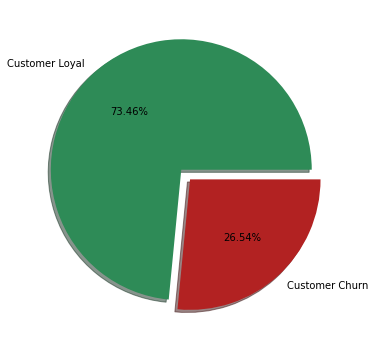

In [13]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.pie(x=df["Churn"].value_counts(),
        colors=["seagreen", "firebrick"], 
        labels=["Customer Loyal", "Customer Churn"], 
        shadow = True, 
        autopct="%1.2f%%",
        explode=(0, 0.1)
        )

plt.show()

In [14]:
df.gender.value_counts()
# 0 = Laki-laki
# 1 = Perempuan

Male      3555
Female    3488
Name: gender, dtype: int64

In [15]:
print ('Total Laki-laki\t: {}'.format(df.gender.value_counts()['Male']))
print ('Total Perempuan\t: {}'.format(df.gender.value_counts()['Female']))

Total Laki-laki	: 3555
Total Perempuan	: 3488


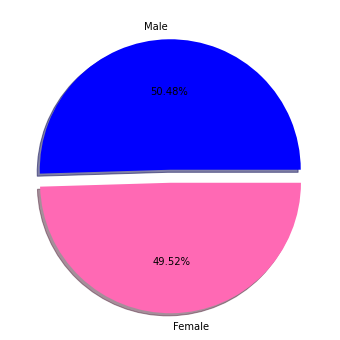

In [16]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.pie(x=df["gender"].value_counts(), 
        colors=["blue", "hotpink"], 
        labels=["Male", "Female"], 
        shadow = True, 
        autopct="%1.2f%%", 
        explode=(0, 0.1)
        )

plt.show()

In [17]:
# Grouping
group = df.groupby('gender').Churn.value_counts()
gender_status = pd.crosstab(df.gender, df.Churn)

print(group)
gender_status

gender  Churn
Female  0        2549
        1         939
Male    0        2625
        1         930
Name: Churn, dtype: int64


Churn,0,1
gender,,
Female,2549,939
Male,2625,930


## 1.3 Feature Category

In [18]:
# Mengetahui kolom apa saja yang termasuk fitur (variabel) numerik/kategoris
numerical_features = df.select_dtypes(include="number").columns.tolist()
categorical_features = df.select_dtypes(include="object").columns.tolist()

print("Numerical features:")
pprint(numerical_features)
print("\nCategorical features:")
pprint(categorical_features, compact=True)

Numerical features:
['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']

Categorical features:
['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
 'PaperlessBilling', 'PaymentMethod']


In [19]:
columns = df.columns
print("********** Numeric field **********n")
for i in range(len(columns)):
    if df[columns[i]].dtypes!=object:
        print("Unique of {} -> {}".format(columns[i], len(df[columns[i]].unique())))
        
print("\n********** Categorical field **********n")
for i in range(len(columns)):
    if df[columns[i]].dtypes==object:
        print("Unique of {} -> {}".format(columns[i], len(df[columns[i]].unique())))

********** Numeric field **********n
Unique of SeniorCitizen -> 2
Unique of tenure -> 73
Unique of MonthlyCharges -> 1585
Unique of TotalCharges -> 6531
Unique of Churn -> 2

********** Categorical field **********n
Unique of gender -> 2
Unique of Partner -> 2
Unique of Dependents -> 2
Unique of PhoneService -> 2
Unique of MultipleLines -> 3
Unique of InternetService -> 3
Unique of OnlineSecurity -> 3
Unique of OnlineBackup -> 3
Unique of DeviceProtection -> 3
Unique of TechSupport -> 3
Unique of StreamingTV -> 3
Unique of StreamingMovies -> 3
Unique of Contract -> 3
Unique of PaperlessBilling -> 2
Unique of PaymentMethod -> 4


In [20]:
for i in range(len(categorical_features)):
    print("********** {} **********".format(categorical_features[i]))
    print(df[categorical_features[i]].unique(), "\n")

********** gender **********
['Female' 'Male'] 

********** Partner **********
['Yes' 'No'] 

********** Dependents **********
['No' 'Yes'] 

********** PhoneService **********
['No' 'Yes'] 

********** MultipleLines **********
['No phone service' 'No' 'Yes'] 

********** InternetService **********
['DSL' 'Fiber optic' 'No'] 

********** OnlineSecurity **********
['No' 'Yes' 'No internet service'] 

********** OnlineBackup **********
['Yes' 'No' 'No internet service'] 

********** DeviceProtection **********
['No' 'Yes' 'No internet service'] 

********** TechSupport **********
['No' 'Yes' 'No internet service'] 

********** StreamingTV **********
['No' 'Yes' 'No internet service'] 

********** StreamingMovies **********
['No' 'Yes' 'No internet service'] 

********** Contract **********
['Month-to-month' 'One year' 'Two year'] 

********** PaperlessBilling **********
['Yes' 'No'] 

********** PaymentMethod **********
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Cre

In [21]:
for i in range(len(numerical_features)):
    print("********** {} **********".format(numerical_features[i]))
    print(df[numerical_features[i]].unique(), "\n")

********** SeniorCitizen **********
[0 1] 

********** tenure **********
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39] 

********** MonthlyCharges **********
[29.85 56.95 53.85 ... 63.1  44.2  78.7 ] 

********** TotalCharges **********
[  29.85 1889.5   108.15 ...  346.45  306.6  6844.5 ] 

********** Churn **********
[0 1] 



## 1.4 Correlation Data
[Referensi Korelasi Data](https://www.scribbr.com/statistics/pearson-correlation-coefficient/)

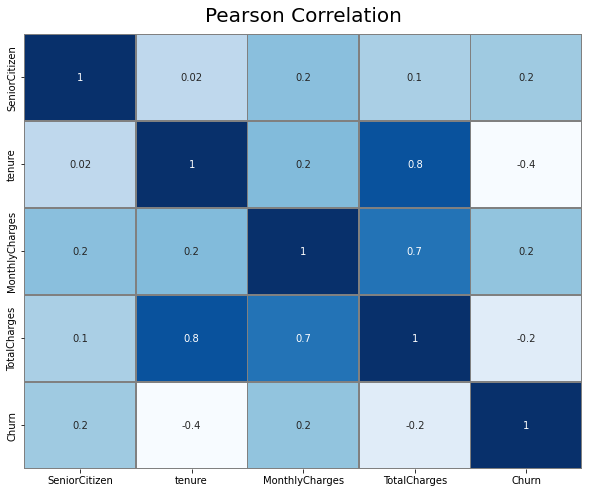

In [22]:
# Having a look at the correlation matrix
fig, ax = plt.subplots(figsize=(10, 8))
heatmap = sns.heatmap(df.corr(), annot=True, fmt='.1g', cmap=plt.cm.Blues, cbar=False, linewidths=0.5, linecolor='grey')
heatmap.set_title('Pearson Correlation', fontdict={'fontsize':20}, pad=12);

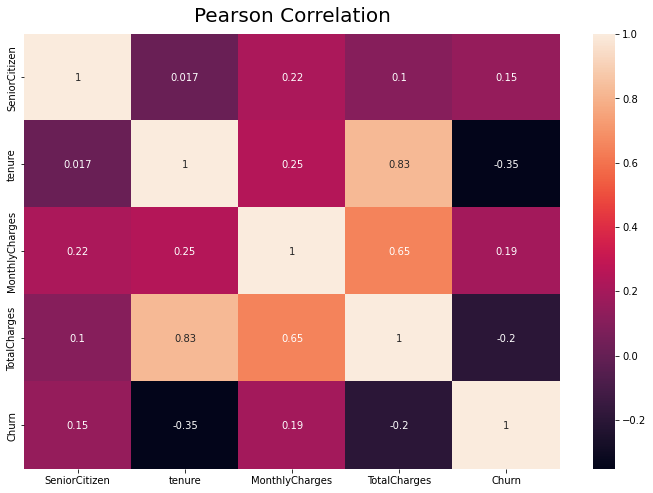

In [23]:
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(df.corr(), annot = True)
heatmap.set_title('Pearson Correlation', fontdict={'fontsize':20}, pad=12);

Text(0.5, 0, 'TotalCharges')

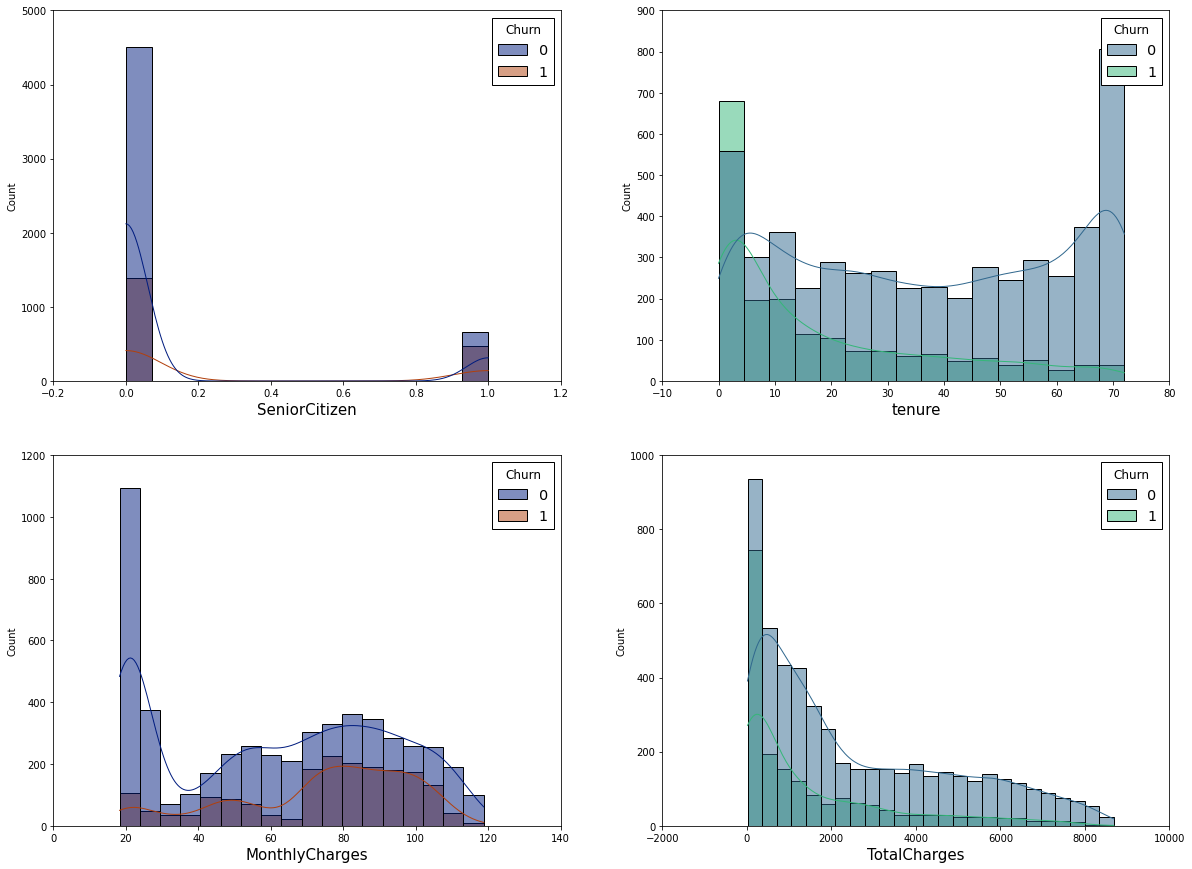

In [24]:
# Numerical Feature Visualization
fig, ax=plt.subplots(2, 2, figsize=(20, 15)) 
plt.style.use("classic")

sns.histplot(x=df["SeniorCitizen"], hue=df["Churn"], palette="dark", kde=True, ax=ax[0,0]);
ax[0,0].set_xlabel("SeniorCitizen", fontsize=15)
sns.histplot(x=df["tenure"], hue=df["Churn"], palette="viridis", kde=True, ax=ax[0,1]);
ax[0,1].set_xlabel("tenure", fontsize=15)
sns.histplot(x=df["MonthlyCharges"], hue=df["Churn"], palette="dark", kde=True, ax=ax[1,0]);
ax[1,0].set_xlabel("MonthlyCharges", fontsize=15)
sns.histplot(x=df["TotalCharges"], hue=df["Churn"], palette="viridis", kde=True, ax=ax[1,1]);
ax[1,1].set_xlabel("TotalCharges", fontsize=15)

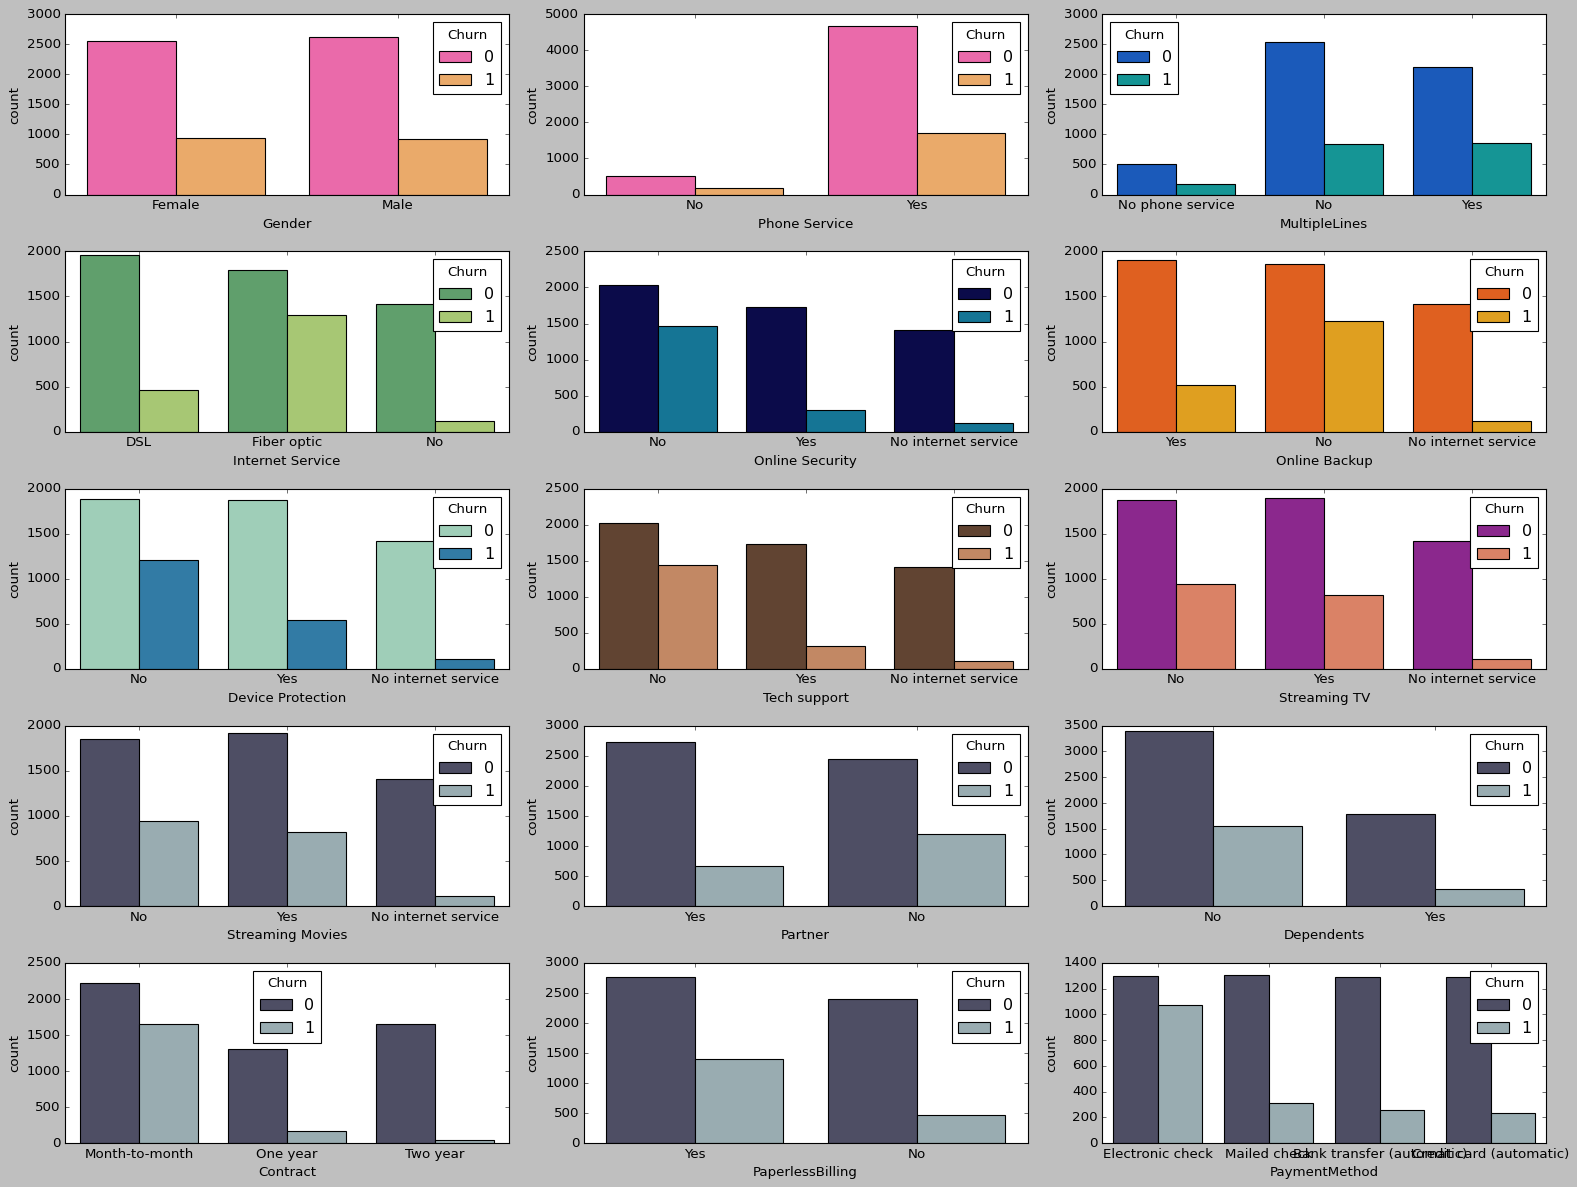

In [25]:
# Categorical Feature Visualization
fig, ax = plt.subplots(5, 3, figsize = (20, 15))

ax1 = sns.countplot(x='gender', data=df, hue='Churn', ax=ax[0, 0], palette='spring')
ax1.set(xlabel='Gender')
ax2 = sns.countplot(x='PhoneService', data=df, hue='Churn', ax=ax[0, 1], palette='spring')
ax2.set(xlabel='Phone Service')
ax3 = sns.countplot(x='MultipleLines', data=df, hue='Churn', ax=ax[0, 2], palette='winter')
ax3.set(xlabel='MultipleLines')
ax4 = sns.countplot(x='InternetService', data=df, hue='Churn', ax=ax[1, 0], palette='summer')
ax4.set(xlabel='Internet Service')
ax5 = sns.countplot(x='OnlineSecurity', data=df, hue='Churn', ax=ax[1, 1], palette='ocean')
ax5.set(xlabel='Online Security')
ax6 = sns.countplot(x='OnlineBackup', data=df, hue='Churn', ax=ax[1, 2], palette='autumn')
ax6.set(xlabel='Online Backup')
ax7 = sns.countplot(x='DeviceProtection', data=df, hue='Churn', ax=ax[2, 0], palette='YlGnBu')
ax7.set(xlabel='Device Protection')
ax8 = sns.countplot(x='TechSupport', data=df, hue='Churn', ax=ax[2, 1], palette='copper')
ax8.set(xlabel='Tech support')
ax9 = sns.countplot(x='StreamingTV', data=df, hue='Churn', ax=ax[2, 2], palette='plasma')
ax9.set(xlabel='Streaming TV')
ax10 = sns.countplot(x='StreamingMovies', data=df, hue='Churn', ax=ax[3, 0], palette='bone')
ax10.set(xlabel='Streaming Movies')
ax11 = sns.countplot(x='Partner', data=df, hue='Churn', ax=ax[3, 1], palette='bone')
ax11.set(xlabel='Partner')
ax12 = sns.countplot(x='Dependents', data=df, hue='Churn', ax=ax[3, 2], palette='bone')
ax12.set(xlabel='Dependents')
ax13 = sns.countplot(x='Contract', data=df, hue='Churn', ax=ax[4, 0], palette='bone')
ax13.set(xlabel='Contract')
ax14 = sns.countplot(x='PaperlessBilling', data=df, hue='Churn', ax=ax[4, 1], palette='bone')
ax14.set(xlabel='PaperlessBilling')
ax15 = sns.countplot(x='PaymentMethod', data=df, hue='Churn', ax=ax[4, 2], palette='bone')
ax15.set(xlabel='PaymentMethod')

plt.tight_layout()
plt.show()

## 1.5 Outlier

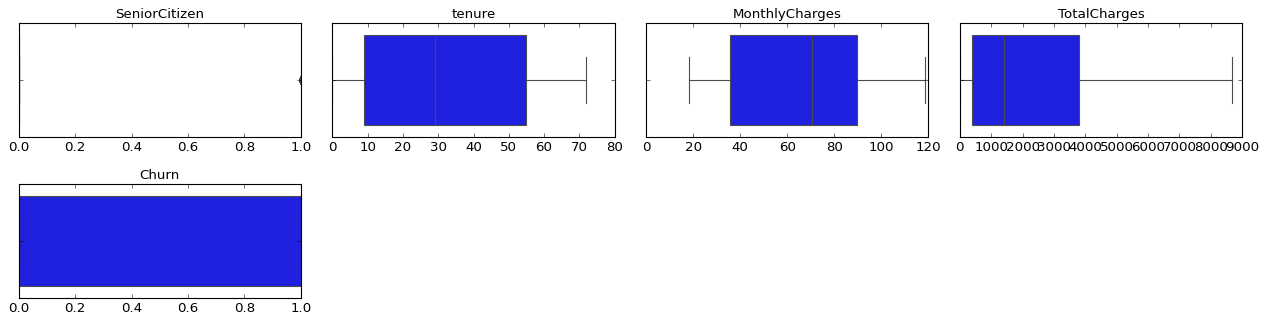

In [26]:
# Numerical Features
plt.figure(figsize=(16, 8), facecolor='white')
plotnumber = 1
    
for feature in numerical_features:
    ax = plt.subplot(4, 4, plotnumber)
    sns.boxplot(x=feature, data=df);
    plt.title(feature, fontsize=12)
    plt.xlabel(None)
    plt.tight_layout()
    plotnumber += 1

> Ada beberapa cara untuk menghilangkan outliers.
* Mengganti nilai outliers menggunakan nilai lower bound dan upper bound.
* Capping menggunakan nilai median
* Capping menggunakan nilai mean
* Capping menggunakan nilai modus

> **Referensi:** [handling outlier](https://blog.sanbercode.com/docs/materi-eda/data-type-missing-value-outlier/)

In [27]:
# # Membuat function IQR Detection
# def outlier(data):
#     q1 = data.quantile(0.25)
#     q3 = data.quantile(0.75)
#     iqr = q3 - q1
#     limit = iqr * 1.5
#     print(f'IQR: {iqr}')
#     upperlimit = q3 + limit
#     lowerlimit = q1 - limit
#     print(f'Upper Limit\t: {upperlimit}')
#     print(f'Lower Limit\t: {lowerlimit}')

# # Buang Outlier
# outlier_feature = [
#                    'tenure',
#                    'MonthlyCharges',
#                    'TotalCharges'
#                   ]

# for i in outlier_feature:
#     print(i)
#     outlier(df[i])
#     print()

# df = df[
#         (df['tenure'] < 125.0) & 
#         (df['MonthlyCharges'] < 172) &
#         (df['TotalCharges'] < 8888)
#        ]

In [28]:
# # Clean dataframe from outlier
# df = df.drop_duplicates()
# df.info()

# 2. Split Data

In [29]:
# Define variable X (Independent variable / features)
X = df.drop('Churn', axis=1)

# Define variable y (Dependent variable / Target features)
Y = df["Churn"]

In [30]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

* X_train: Untuk menampung data source yang akan dilatih.
* X_test: Untuk menampung data target yang akan dilatih.
* Y_train: Untuk menampung data source yang akan digunakan untuk testing.
* Y_test: Untuk menampung data target yang akan digunakan untuk testing.

In [31]:
len(X_train), len(X_test)

(5634, 1409)

In [32]:
print("Jumlah X Train", X_train.shape)
print("Jumlah X Test", X_test.shape)

Jumlah X Train (5634, 19)
Jumlah X Test (1409, 19)


In [33]:
print("Data Train:")
pprint(Y_train.value_counts())

print("\nData Test:")
pprint(Y_test.value_counts())

Data Train:
0    4138
1    1496
Name: Churn, dtype: int64

Data Test:
0    1036
1     373
Name: Churn, dtype: int64


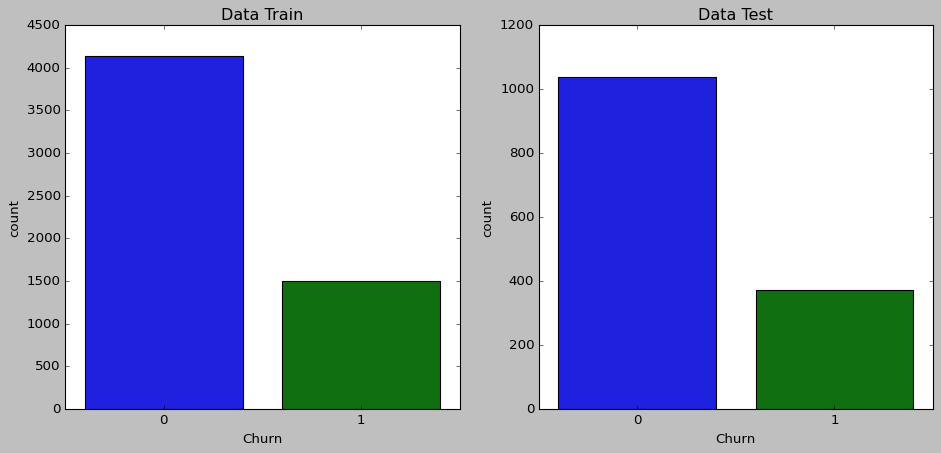

In [34]:
fig, axis = plt.subplots(1, 2, figsize=(14, 6))
for idx, label in enumerate([
    (Y_train, "Data Train"), (Y_test, "Data Test")
]):
    sns.countplot(x=label[0], ax=axis[idx])
    axis[idx].set_title(label[1])
    axis[idx].grid(False)
plt.show()

# 3. Categorical Encoding

> **Note:** Jenis-Jenis Tipe Data
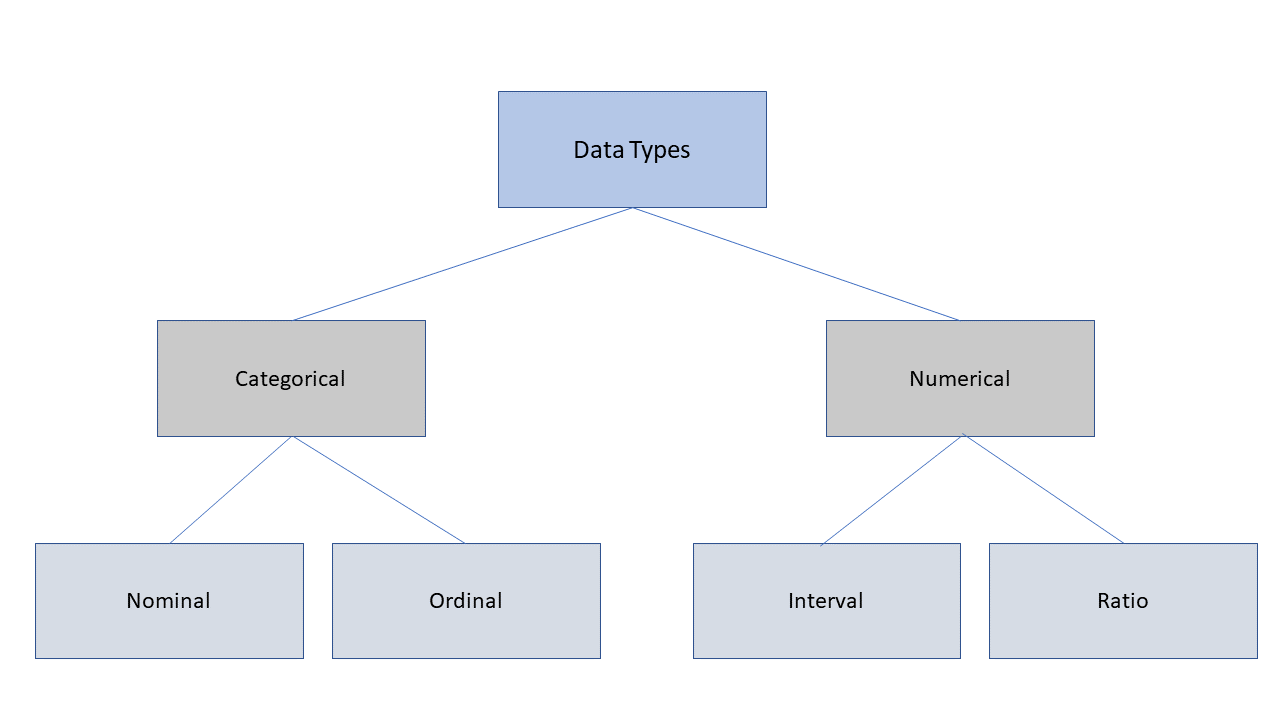

1. Data Nominal: Data nominal adalah data yang dapat diklasifikasikan ke dalam kategori atau label tanpa urutan tertentu. Contoh: jenis kelamin (Pria/Wanita), warna (Merah/Biru/Hijau), dll.
2. Data Ordinal: Data ordinal adalah data yang dapat diklasifikasikan ke dalam kategori atau label dengan urutan tertentu. Contoh: tingkat pendidikan (SD/SMP/SMA/Perguruan Tinggi), tingkat kesukaan (Sangat Tidak Suka/Tidak Suka/Netral/Suka/Sangat Suka), dll.
3. Data Interval: Data interval adalah data yang dapat diukur dalam skala yang tidak terbatas namun tidak memiliki nilai nol absolut. Contoh: suhu dalam derajat Fahrenheit, skala IQ, dll.
4. Data Rasio: Data rasio adalah data yang dapat diukur dalam skala yang tidak terbatas dan memiliki nilai nol absolut. Contoh: berat badan, tinggi badan, dll.

> **NOTE:**
> Perbedaan utama antara tipe data tersebut terletak pada cara data diukur dan diinterpretasikan. Data nominal hanya dapat di klasifikasikan, data ordinal memiliki urutan, data interval tidak memiliki nilai nol absolut, sementara data rasio memiliki nilai nol absolut sehingga dapat diukur perbandingannya.

1. Data kontinu: Data kontinu adalah data yang dapat diukur dalam skala yang tidak terbatas, seperti suhu, berat, tinggi, dll. Data ini dapat dinyatakan dalam bentuk angka decimal. Contoh : suhu tubuh, berat badan, tinggi badan, dll.
2. Data diskrit: Data diskrit adalah data yang dapat dihitung dan dinyatakan dalam bentuk angka bulat. Data diskrit dapat diklasifikasikan ke dalam kategori atau label. Contoh : jumlah anak, jenis kelamin, jenis pekerjaan, dll.
3. Data binari: Data binari adalah data yang hanya dapat memiliki dua nilai, yaitu 0 atau 1. Data ini sering digunakan dalam klasifikasi biner (binary classification), dimana setiap sampel diklasifikasikan sebagai kategori positif atau negatif. Contoh : status menikah (Menikah/Belum Menikah), status memiliki kartu kredit (ya/tidak), dll.

> **NOTE:**
> Perbedaan utama antara data kontinu, diskrit dan binari terletak pada cara data diukur dan diinterpretasikan. Data kontinu diukur dalam skala yang tidak terbatas, data diskrit diukur dalam skala yang terbatas dan dapat dihitung, sementara data binari hanya memiliki dua nilai yang mungkin.

* Dilihat dari isi value masing-masing fitur, maka encoding akan terbagi menjadi 2 yaitu: 
> 1. ***Ordinal Encoding*** untuk fitur kategorik tipe data ordinal.
> 2. ***One Hot Encoding*** untuk fitur kategorik tipe data nominal, interval, dan rasio.

In [35]:
numeric_data = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
# Untuk Uji One Hot Encoding
nominal_data = ['gender', 'InternetService', 'PaymentMethod']
# Untuk Uji Ordinal Encoding
ordinal_data = X.select_dtypes(include="object").drop(columns=nominal_data).columns.tolist()

print("Numeric Data:")
pprint(numeric_data)
print("\nNominal Data:")
pprint(nominal_data)
print("\nOrdinal Data:")
pprint(ordinal_data, compact=True)

Numeric Data:
['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

Nominal Data:
['gender', 'InternetService', 'PaymentMethod']

Ordinal Data:
['Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity',
 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
 'StreamingMovies', 'Contract', 'PaperlessBilling']


## 2.1 One Hot Encoding

In [36]:
# Encoding pada nominal features
onehot = OneHotEncoder()
onehot.fit(X_train[nominal_data])

X_train_ohe = pd.DataFrame(
                        onehot.transform(X_train[nominal_data]).toarray(),
                        columns=onehot.get_feature_names_out()
                        )
X_test_ohe = pd.DataFrame(
                        onehot.transform(X_test[nominal_data]).toarray(),
                        columns=onehot.get_feature_names_out()
                        )

# Menampilkan dataFrame hasil one hot encoding
print("One Hot Data Train:")
display(X_train_ohe)
print("One Hot Data Test:")
display(X_test_ohe)

One Hot Data Train:


,gender_Female,gender_Male,InternetService_DSL,InternetService_Fiber optic,InternetService_No,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
5629,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5630,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5631,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5632,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


One Hot Data Test:


,gender_Female,gender_Male,InternetService_DSL,InternetService_Fiber optic,InternetService_No,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1404,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1405,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1406,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1407,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


## 2.2 Ordinal Encoding

In [37]:
# Encoding pada ordinal features
ordinal = OrdinalEncoder()
ordinal.fit(X_train[ordinal_data])

X_train_oe = pd.DataFrame(
                        ordinal.transform(X_train[ordinal_data]),
                        columns=ordinal.feature_names_in_
                       )
X_test_oe = pd.DataFrame(
                        ordinal.transform(X_test[ordinal_data]),
                        columns=ordinal.feature_names_in_
                       )

# Menampilkan DataFrame hasil ordinal encoding
print("Ordinal Data Train:")
display(X_train_oe)
print("Ordinal Data Test:")
display(X_test_oe)

Ordinal Data Train:


,Partner,Dependents,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling
0,0.0,1.0,1.0,0.0,2.0,0.0,2.0,0.0,0.0,2.0,1.0,0.0
1,0.0,0.0,1.0,2.0,0.0,2.0,0.0,0.0,2.0,2.0,2.0,1.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,1.0,2.0,2.0,2.0,0.0,2.0,0.0,0.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5629,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,2.0,2.0,0.0,1.0
5630,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0
5631,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
5632,0.0,0.0,1.0,2.0,0.0,0.0,2.0,0.0,2.0,2.0,0.0,1.0


Ordinal Data Test:


,Partner,Dependents,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
2,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1404,1.0,0.0,1.0,0.0,0.0,2.0,2.0,2.0,0.0,2.0,2.0,1.0
1405,1.0,1.0,1.0,2.0,2.0,2.0,0.0,2.0,2.0,2.0,1.0,0.0
1406,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1407,1.0,1.0,0.0,1.0,2.0,0.0,2.0,0.0,0.0,2.0,2.0,1.0


In [38]:
# Menggabungkan DataFrame menggunakan pandas function pd
X_train_combined = pd.concat(
                              [X_train[numeric_data].reset_index(drop=True), 
                              X_train_ohe, 
                              X_train_oe],
                              axis=1
                            )

X_test_combined = pd.concat(
                             [X_test[numeric_data].reset_index(drop=True), 
                             X_test_ohe, X_test_oe],
                             axis=1
                           )

print("Kombinasi Encoding Data Train:")
display(X_train_combined.head())
print("Kombinasi Encoding Data Test:")
display(X_test_combined.head())

Kombinasi Encoding Data Train:


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,InternetService_DSL,InternetService_Fiber optic,InternetService_No,PaymentMethod_Bank transfer (automatic),...,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling
0,0,21,64.85,1336.800,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,2.0,0.0,2.0,0.0,0.0,2.0,1.0,0.0
1,0,54,97.20,5129.450,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,2.0,0.0,2.0,0.0,0.0,2.0,2.0,2.0,1.0
2,0,1,23.45,23.450,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,4,70.20,237.950,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,0,61.90,1397.475,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,2.0,2.0,2.0,0.0,2.0,0.0,0.0,2.0,1.0


Kombinasi Encoding Data Test:


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,InternetService_DSL,InternetService_Fiber optic,InternetService_No,PaymentMethod_Bank transfer (automatic),...,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling
0,0,1,24.80,24.80,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,41,25.25,996.45,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
2,0,52,19.35,1031.70,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,0.0
3,0,1,76.35,76.35,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
4,0,67,50.55,3260.10,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0


# 4. Normalization

In [39]:
mms = MinMaxScaler()
mms.fit(X_train_combined)

X_train_scaled = pd.DataFrame(
                               mms.transform(X_train_combined),
                               columns=X_train_combined.columns
                             )

X_test_scaled = pd.DataFrame(
                              mms.transform(X_test_combined),
                              columns=X_test_combined.columns
                            )

with pd.option_context("display.max_columns", None):
  display(X_train_scaled.head())
  display(X_test_scaled.head())

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,InternetService_DSL,InternetService_Fiber optic,InternetService_No,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Partner,Dependents,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling
0,0.0,0.291667,0.464375,0.152089,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.5,0.0
1,0.0,0.750000,0.786746,0.589736,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
2,0.0,0.013889,0.051819,0.000537,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.055556,0.517688,0.025288,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.000000,0.434978,0.159090,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,InternetService_DSL,InternetService_Fiber optic,InternetService_No,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Partner,Dependents,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling
0,0.0,0.013889,0.065272,0.000692,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.569444,0.069756,0.112814,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.5,0.5,0.5,0.5,0.5,0.5,0.0,1.0
2,0.0,0.722222,0.010962,0.116882,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.5,0.5,0.5,0.5,0.5,0.5,1.0,0.0
3,0.0,0.013889,0.578974,0.006641,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.930556,0.321873,0.374025,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


# 5. Modelling

In [40]:
# Define SMOTE Data Train
smote = SMOTE()
X_smote_train, Y_smote_train = smote.fit_resample(X_train_scaled, Y_train)

print('Original dataset shape is', Counter(Y_train))
print('Resample dataset shape is', Counter(Y_smote_train))
print("\n==========")
print(X_smote_train.shape)
print(Y_smote_train.shape)

print("\n********************")

# Define SMOTE Data Test
smote = SMOTE()
X_smote_test, Y_smote_test = smote.fit_resample(X_test_scaled, Y_test)

print('Original dataset shape is', Counter(Y_test))
print('Resample dataset shape is', Counter(Y_smote_test))
print("\n==========")
print(X_smote_test.shape)
print(Y_smote_test.shape)

Original dataset shape is Counter({0: 4138, 1: 1496})
Resample dataset shape is Counter({0: 4138, 1: 4138})

(8276, 25)
(8276,)

********************
Original dataset shape is Counter({0: 1036, 1: 373})
Resample dataset shape is Counter({1: 1036, 0: 1036})

(2072, 25)
(2072,)


In [41]:
X_smote_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8276 entries, 0 to 8275
Data columns (total 25 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   SeniorCitizen                            8276 non-null   float64
 1   tenure                                   8276 non-null   float64
 2   MonthlyCharges                           8276 non-null   float64
 3   TotalCharges                             8276 non-null   float64
 4   gender_Female                            8276 non-null   float64
 5   gender_Male                              8276 non-null   float64
 6   InternetService_DSL                      8276 non-null   float64
 7   InternetService_Fiber optic              8276 non-null   float64
 8   InternetService_No                       8276 non-null   float64
 9   PaymentMethod_Bank transfer (automatic)  8276 non-null   float64
 10  PaymentMethod_Credit card (automatic)    8276 no

In [42]:
X_smote_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2072 entries, 0 to 2071
Data columns (total 25 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   SeniorCitizen                            2072 non-null   float64
 1   tenure                                   2072 non-null   float64
 2   MonthlyCharges                           2072 non-null   float64
 3   TotalCharges                             2072 non-null   float64
 4   gender_Female                            2072 non-null   float64
 5   gender_Male                              2072 non-null   float64
 6   InternetService_DSL                      2072 non-null   float64
 7   InternetService_Fiber optic              2072 non-null   float64
 8   InternetService_No                       2072 non-null   float64
 9   PaymentMethod_Bank transfer (automatic)  2072 non-null   float64
 10  PaymentMethod_Credit card (automatic)    2072 no

In [43]:
classifier = {
    "LightGBM": lgbm.LGBMClassifier(),
    "XGBoost": XGBClassifier(),
    "GradientBoosting": GradientBoostingClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Logistic Regression": LogisticRegression(),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier()
}

In [44]:
train_scores = []
test_scores = []

for key, model in classifier.items():
  model.fit(X_smote_train, Y_smote_train)
  train_score = model.score(X_smote_train, Y_smote_train)
  train_scores.append(train_score)
  test_score = model.score(X_smote_test, Y_smote_test)
  test_scores.append(test_score)

# print("Hasil Nilai Data Train\t:", train_scores)
# print("Hasil Nilai Data Test\t:", test_scores)

In [45]:
klasifikasi = ["LightGBM", "XGBoost", "GradientBoosting", "Random Forest", "Logistic Regression", "Naive Bayes", "Decision Tree", "KNN"]

prediksi = pd.DataFrame({"Nama Model": klasifikasi, "Nilai Data Train": train_scores, "Nilai Data Test": test_scores})
prediksi

,Nama Model,Nilai Data Train,Nilai Data Test
0,LightGBM,0.903456,0.853764
1,XGBoost,0.850048,0.852317
2,GradientBoosting,0.850411,0.854730
3,Random Forest,0.999033,0.823359
4,Logistic Regression,0.773079,0.795367
5,Naive Bayes,0.763654,0.789093
6,Decision Tree,0.999033,0.732143
7,KNN,0.857177,0.725386


In [46]:
# Evaluation Metrics
def classification_matrix (aktual, prediksi, name):
    cm = confusion_matrix(aktual, prediksi)
    tp = cm[1][1]
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    
    accuracy = round((tp + tn) / (tp + tn + fp + fn) * 100, 2)
    precision = round((tp) / (tp + fp) * 100, 2)
    recall = round((tp) / (tp + fn) * 100, 2)
    f1_score = round((2 * (precision * recall) / (precision + recall)))
    
    print('Evaluation Model:', name)
    print(cm)
    print('Accuracy   :', accuracy, '%')
    print('Precision  :', precision, '%')
    print('Recall     :', recall, '%')
    print('F1_Score   :', f1_score, '%')

## 5.1 Random Forest
Referensi Model Random Forest
1. [Selected Features](https://www.datacamp.com/tutorial/random-forests-classifier-python)
2. [Estimator Tree](https://www.kaggle.com/code/prashant111/random-forest-classifier-feature-importance#Random-Forest-Classifier-with-Feature-Importance)

### 5.1.1 Test Estimator

#### a. Entropy

In [47]:
from sklearn.ensemble import RandomForestClassifier

entropy = RandomForestClassifier(n_estimators=1000, criterion='entropy', random_state=0)
entropy.fit(X_smote_train, Y_smote_train)

RandomForestClassifier(criterion='entropy', n_estimators=1000, random_state=0)

In [48]:
y_pred_entropy = entropy.predict(X_smote_test)

In [49]:
from sklearn.metrics import roc_curve, auc

false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_smote_test, y_pred_entropy)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.8238416988416989

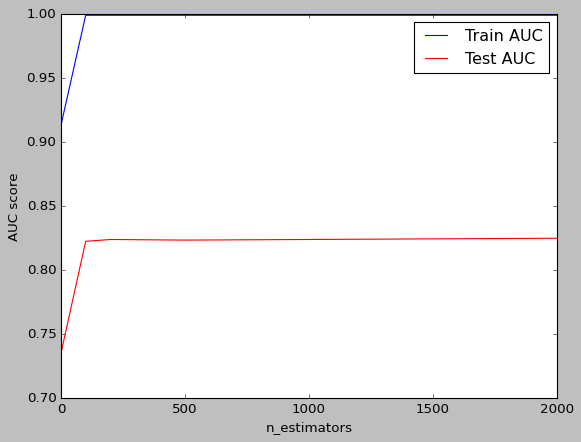

In [50]:
n_estimators = [1, 100, 200, 500, 1000, 2000]
train_results = []
test_results = []

for estimator in n_estimators:
   entropy_rf = RandomForestClassifier(criterion='entropy', random_state=0, n_estimators=estimator, n_jobs=-1)
   entropy_rf.fit(X_smote_train, Y_smote_train)
   
   x_pred_entropy = entropy_rf.predict(X_smote_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_smote_train, x_pred_entropy)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)

   y_pred_entropy = entropy_rf.predict(X_smote_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_smote_test, y_pred_entropy)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(n_estimators, train_results, "b", label="Train AUC")
line2, = plt.plot(n_estimators, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show()

#### b. Gini

In [51]:
from sklearn.ensemble import RandomForestClassifier

gini = RandomForestClassifier(n_estimators=2000, criterion='gini', random_state=0)
gini.fit(X_smote_train, Y_smote_train)

RandomForestClassifier(n_estimators=2000, random_state=0)

In [52]:
y_pred_gini = gini.predict(X_smote_test)

In [53]:
from sklearn.metrics import roc_curve, auc

false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_smote_test, y_pred_gini)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.8267374517374517

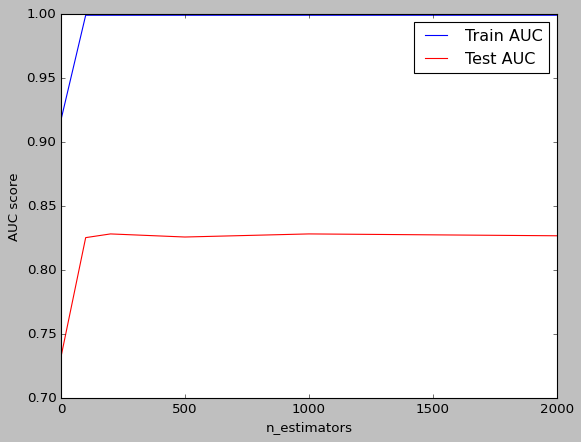

In [54]:
n_estimators = [1, 100, 200, 500, 1000, 2000]
train_results = []
test_results = []

for estimator in n_estimators:
   gini_rf = RandomForestClassifier(criterion='gini', random_state=0, n_estimators=estimator, n_jobs=-1)
   gini_rf.fit(X_smote_train, Y_smote_train)
   
   x_pred_gini = gini_rf.predict(X_smote_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_smote_train, x_pred_gini)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)

   y_pred_gini = gini_rf.predict(X_smote_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_smote_test, y_pred_gini)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(n_estimators, train_results, "b", label="Train AUC")
line2, = plt.plot(n_estimators, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show()

### 5.1.2 Entropy

#### a. 100 Trees = 82%

Training Accuracy	: 100
Testing Accuracy	: 82

**********



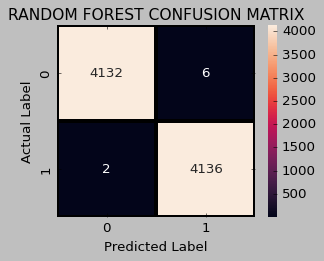


**********



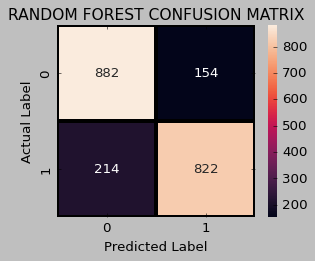

In [55]:
# instantiate the classifier with n_estimators = 100
model_rfc_100 = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0)

# fit the model to the training set
model_rfc_100.fit(X_smote_train, Y_smote_train)

# Predict on the test set results
Y_train_rfc_100 = model_rfc_100.predict(X_smote_train)
Y_test_rfc_100 = model_rfc_100.predict(X_smote_test)

# Check accuracy score 
print("Training Accuracy\t: {0:.0f}".format(model_rfc_100.score(X_smote_train, Y_smote_train)*100))
print("Testing Accuracy\t: {0:.0f}".format(model_rfc_100.score(X_smote_test, Y_smote_test)*100))

print("\n**********\n")

# CONFUSION MATRIX DATA TRAIN
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(Y_smote_train, Y_train_rfc_100),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title("RANDOM FOREST CONFUSION MATRIX",fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

print("\n**********\n")

# CONFUSION MATRIX DATA TEST
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(Y_smote_test, Y_test_rfc_100),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title("RANDOM FOREST CONFUSION MATRIX",fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [56]:
model_rfc_100 = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0)
model_rfc_100.fit(X_smote_train, Y_smote_train)

Y_train_rfc_100 = model_rfc_100.predict(X_smote_train)
Y_test_rfc_100 = model_rfc_100.predict(X_smote_test)

In [57]:
classification_matrix(Y_smote_train, Y_train_rfc_100, 'Random Forest Training')

Evaluation Model: Random Forest Training
[[4132    6]
 [   2 4136]]
Accuracy   : 99.9 %
Precision  : 99.86 %
Recall     : 99.95 %
F1_Score   : 100 %


In [58]:
print(metrics.classification_report(Y_smote_train, Y_train_rfc_100))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4138
           1       1.00      1.00      1.00      4138

    accuracy                           1.00      8276
   macro avg       1.00      1.00      1.00      8276
weighted avg       1.00      1.00      1.00      8276



In [59]:
classification_matrix(Y_smote_test, Y_test_rfc_100, 'Random Forest Testing')

Evaluation Model: Random Forest Testing
[[882 154]
 [214 822]]
Accuracy   : 82.24 %
Precision  : 84.22 %
Recall     : 79.34 %
F1_Score   : 82 %


In [60]:
print(metrics.classification_report(Y_smote_test, Y_test_rfc_100))

              precision    recall  f1-score   support

           0       0.80      0.85      0.83      1036
           1       0.84      0.79      0.82      1036

    accuracy                           0.82      2072
   macro avg       0.82      0.82      0.82      2072
weighted avg       0.82      0.82      0.82      2072



#### b. 200 Trees = 82%

Training Accuracy	: 100
Testing Accuracy	: 82

**********



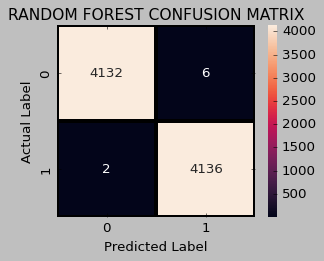


**********



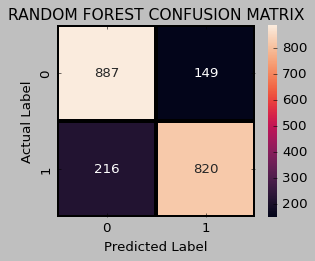

In [61]:
# instantiate the classifier with n_estimators = 100
model_rfc_200 = RandomForestClassifier(n_estimators=200, criterion='entropy', random_state=0)

# fit the model to the training set
model_rfc_200.fit(X_smote_train, Y_smote_train)

# Predict on the test set results
Y_train_rfc_200 = model_rfc_200.predict(X_smote_train)
Y_test_rfc_200 = model_rfc_200.predict(X_smote_test)

# Check accuracy score 
print("Training Accuracy\t: {0:.0f}".format(model_rfc_200.score(X_smote_train, Y_smote_train)*100))
print("Testing Accuracy\t: {0:.0f}".format(model_rfc_200.score(X_smote_test, Y_smote_test)*100))

print("\n**********\n")

# CONFUSION MATRIX DATA TRAIN
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(Y_smote_train, Y_train_rfc_200),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title("RANDOM FOREST CONFUSION MATRIX",fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

print("\n**********\n")

# CONFUSION MATRIX DATA TEST
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(Y_smote_test, Y_test_rfc_200),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title("RANDOM FOREST CONFUSION MATRIX",fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [62]:
model_rfc_200 = RandomForestClassifier(n_estimators=200, criterion='entropy', random_state=0)
model_rfc_200.fit(X_smote_train, Y_smote_train)

Y_train_rfc_200 = model_rfc_200.predict(X_smote_train)
Y_test_rfc_200 = model_rfc_200.predict(X_smote_test)

In [63]:
classification_matrix(Y_smote_train, Y_train_rfc_200, 'Random Forest Training')

Evaluation Model: Random Forest Training
[[4132    6]
 [   2 4136]]
Accuracy   : 99.9 %
Precision  : 99.86 %
Recall     : 99.95 %
F1_Score   : 100 %


In [64]:
print(metrics.classification_report(Y_smote_train, Y_train_rfc_200))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4138
           1       1.00      1.00      1.00      4138

    accuracy                           1.00      8276
   macro avg       1.00      1.00      1.00      8276
weighted avg       1.00      1.00      1.00      8276



In [65]:
classification_matrix(Y_smote_test, Y_test_rfc_200, 'Random Forest Testing')

Evaluation Model: Random Forest Testing
[[887 149]
 [216 820]]
Accuracy   : 82.38 %
Precision  : 84.62 %
Recall     : 79.15 %
F1_Score   : 82 %


In [66]:
print(metrics.classification_report(Y_smote_test, Y_test_rfc_200))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1036
           1       0.85      0.79      0.82      1036

    accuracy                           0.82      2072
   macro avg       0.83      0.82      0.82      2072
weighted avg       0.83      0.82      0.82      2072



#### c. 500 Trees = 83%

Training Accuracy	: 100
Testing Accuracy	: 82

**********



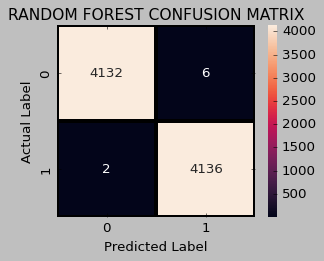


**********



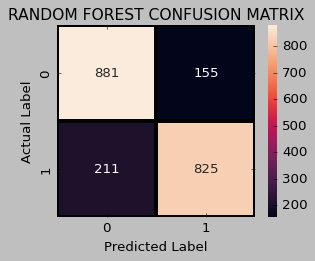

In [67]:
# instantiate the classifier with n_estimators = 500
model_rfc_500 = RandomForestClassifier(n_estimators=500, criterion='entropy', random_state=0)

# fit the model to the training set
model_rfc_500.fit(X_smote_train, Y_smote_train)

# Predict on the test set results
Y_train_rfc_500 = model_rfc_500.predict(X_smote_train)
Y_test_rfc_500 = model_rfc_500.predict(X_smote_test)

# Check accuracy score 
print("Training Accuracy\t: {0:.0f}".format(model_rfc_500.score(X_smote_train, Y_smote_train)*100))
print("Testing Accuracy\t: {0:.0f}".format(model_rfc_500.score(X_smote_test, Y_smote_test)*100))

print("\n**********\n")

# CONFUSION MATRIX DATA TRAIN
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(Y_smote_train, Y_train_rfc_500),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title("RANDOM FOREST CONFUSION MATRIX",fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

print("\n**********\n")

# CONFUSION MATRIX DATA TEST
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(Y_smote_test, Y_test_rfc_500),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title("RANDOM FOREST CONFUSION MATRIX",fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [68]:
model_rfc_500 = RandomForestClassifier(n_estimators=500, criterion='entropy', random_state=0)
model_rfc_500.fit(X_smote_train, Y_smote_train)

Y_train_rfc_500 = model_rfc_500.predict(X_smote_train)
Y_test_rfc_500 = model_rfc_500.predict(X_smote_test)

In [69]:
classification_matrix(Y_smote_train, Y_train_rfc_500, 'Random Forest Training')

Evaluation Model: Random Forest Training
[[4132    6]
 [   2 4136]]
Accuracy   : 99.9 %
Precision  : 99.86 %
Recall     : 99.95 %
F1_Score   : 100 %


In [70]:
print(metrics.classification_report(Y_smote_train, Y_train_rfc_500))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4138
           1       1.00      1.00      1.00      4138

    accuracy                           1.00      8276
   macro avg       1.00      1.00      1.00      8276
weighted avg       1.00      1.00      1.00      8276



In [71]:
classification_matrix(Y_smote_test, Y_test_rfc_500, 'Random Forest Testing')

Evaluation Model: Random Forest Testing
[[881 155]
 [211 825]]
Accuracy   : 82.34 %
Precision  : 84.18 %
Recall     : 79.63 %
F1_Score   : 82 %


In [72]:
print(metrics.classification_report(Y_smote_test, Y_test_rfc_500))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1036
           1       0.84      0.80      0.82      1036

    accuracy                           0.82      2072
   macro avg       0.82      0.82      0.82      2072
weighted avg       0.82      0.82      0.82      2072



#### d. 1000 Trees = 83% -> Dipilih

Training Accuracy	: 100
Testing Accuracy	: 82

**********



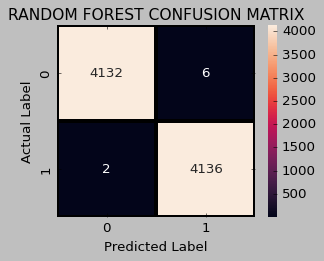


**********



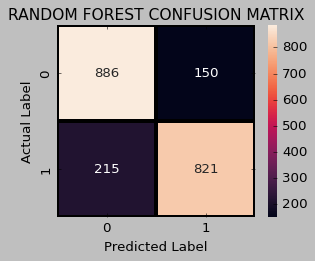

In [73]:
# instantiate the classifier with n_estimators = 1000
entropy_rfc_1000 = RandomForestClassifier(n_estimators=1000, criterion='entropy', random_state=0)

# fit the model to the training set
entropy_rfc_1000.fit(X_smote_train, Y_smote_train)

# Predict on the test set results
Y_train_rfc_1000 = entropy_rfc_1000.predict(X_smote_train)
Y_test_rfc_1000 = entropy_rfc_1000.predict(X_smote_test)

# Check accuracy score 
print("Training Accuracy\t: {0:.0f}".format(entropy_rfc_1000.score(X_smote_train, Y_smote_train)*100))
print("Testing Accuracy\t: {0:.0f}".format(entropy_rfc_1000.score(X_smote_test, Y_smote_test)*100))

print("\n**********\n")

# CONFUSION MATRIX DATA TRAIN
plt.figure(figsize=(4, 3))
sns.heatmap(
            confusion_matrix(Y_smote_train, Y_train_rfc_1000),
            annot=True,
            fmt="d",
            linecolor="k",
            linewidths=3
           )
    
plt.title("RANDOM FOREST CONFUSION MATRIX", fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

print("\n**********\n")

# CONFUSION MATRIX DATA TEST
plt.figure(figsize=(4, 3))
sns.heatmap(
            confusion_matrix(Y_smote_test, Y_test_rfc_1000),
            annot=True,
            fmt="d",
            linecolor="k",
            linewidths=3
           )
    
plt.title("RANDOM FOREST CONFUSION MATRIX", fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [74]:
classification_matrix(Y_smote_train, Y_train_rfc_1000, 'Random Forest Training')

Evaluation Model: Random Forest Training
[[4132    6]
 [   2 4136]]
Accuracy   : 99.9 %
Precision  : 99.86 %
Recall     : 99.95 %
F1_Score   : 100 %


In [75]:
print(metrics.classification_report(Y_smote_train, Y_train_rfc_1000))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4138
           1       1.00      1.00      1.00      4138

    accuracy                           1.00      8276
   macro avg       1.00      1.00      1.00      8276
weighted avg       1.00      1.00      1.00      8276



In [76]:
classification_matrix(Y_smote_test, Y_test_rfc_1000, 'Random Forest Testing')

Evaluation Model: Random Forest Testing
[[886 150]
 [215 821]]
Accuracy   : 82.38 %
Precision  : 84.55 %
Recall     : 79.25 %
F1_Score   : 82 %


In [77]:
print(metrics.classification_report(Y_smote_test, Y_test_rfc_1000))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1036
           1       0.85      0.79      0.82      1036

    accuracy                           0.82      2072
   macro avg       0.83      0.82      0.82      2072
weighted avg       0.83      0.82      0.82      2072



#### e. 2000 Trees = 83%

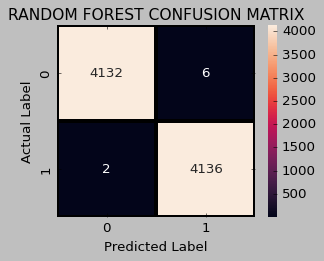


**********



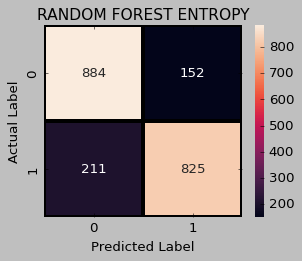


**********

Training Accuracy	: 100
Testing Accuracy	: 82


In [78]:
# instantiate the classifier with n_estimators = 2000
entropy_rfc_2000 = RandomForestClassifier(n_estimators=2000, criterion='entropy', random_state=0)

# fit the model to the training set
entropy_rfc_2000.fit(X_smote_train, Y_smote_train)

# Predict on the test set results
Y_train_rfc_2000 = entropy_rfc_2000.predict(X_smote_train)
Y_test_rfc_2000 = entropy_rfc_2000.predict(X_smote_test)

# CONFUSION MATRIX DATA TRAIN
plt.figure(figsize=(4, 3))
sns.heatmap(
            confusion_matrix(Y_smote_train, Y_train_rfc_2000),
            annot=True, 
            fmt="d", 
            linecolor="k",
            linewidths=3
           )
    
plt.title("RANDOM FOREST CONFUSION MATRIX", fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

print("\n**********\n")

# CONFUSION MATRIX DATA TEST
plt.figure(figsize=(4, 3))
sns.heatmap(
            confusion_matrix(Y_smote_test, Y_test_rfc_2000),
            annot=True, 
            fmt="d", 
            linecolor="k", 
            linewidths=3
           )
    
plt.title("RANDOM FOREST ENTROPY", fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

print("\n**********\n")

# Check accuracy score 
print("Training Accuracy\t: {0:.0f}".format(entropy_rfc_2000.score(X_smote_train, Y_smote_train)*100))
print("Testing Accuracy\t: {0:.0f}".format(entropy_rfc_2000.score(X_smote_test, Y_smote_test)*100))

In [79]:
classification_matrix(Y_smote_train, Y_train_rfc_2000, 'Random Forest Training')

Evaluation Model: Random Forest Training
[[4132    6]
 [   2 4136]]
Accuracy   : 99.9 %
Precision  : 99.86 %
Recall     : 99.95 %
F1_Score   : 100 %


In [80]:
print(metrics.classification_report(Y_smote_train, Y_train_rfc_2000))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4138
           1       1.00      1.00      1.00      4138

    accuracy                           1.00      8276
   macro avg       1.00      1.00      1.00      8276
weighted avg       1.00      1.00      1.00      8276



In [81]:
classification_matrix(Y_smote_test, Y_test_rfc_2000, 'Random Forest Testing')

Evaluation Model: Random Forest Testing
[[884 152]
 [211 825]]
Accuracy   : 82.48 %
Precision  : 84.44 %
Recall     : 79.63 %
F1_Score   : 82 %


In [82]:
print(metrics.classification_report(Y_smote_test, Y_test_rfc_2000))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1036
           1       0.84      0.80      0.82      1036

    accuracy                           0.82      2072
   macro avg       0.83      0.82      0.82      2072
weighted avg       0.83      0.82      0.82      2072



### 5.1.3 Gini

#### a. 100 Trees = 82%

Training Accuracy	: 100
Testing Accuracy	: 83

**********



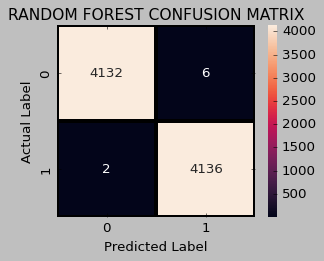


**********



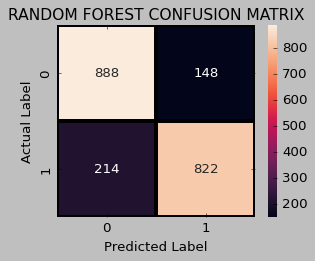

In [83]:
# instantiate the classifier with n_estimators = 100
model_rfc_100 = RandomForestClassifier(n_estimators=100, criterion='gini', random_state=0)

# fit the model to the training set
model_rfc_100.fit(X_smote_train, Y_smote_train)

# Predict on the test set results
Y_train_rfc_100 = model_rfc_100.predict(X_smote_train)
Y_test_rfc_100 = model_rfc_100.predict(X_smote_test)

# Check accuracy score 
print("Training Accuracy\t: {0:.0f}".format(model_rfc_100.score(X_smote_train, Y_smote_train)*100))
print("Testing Accuracy\t: {0:.0f}".format(model_rfc_100.score(X_smote_test, Y_smote_test)*100))

print("\n**********\n")

# CONFUSION MATRIX DATA TRAIN
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(Y_smote_train, Y_train_rfc_100),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title("RANDOM FOREST CONFUSION MATRIX",fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

print("\n**********\n")

# CONFUSION MATRIX DATA TEST
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(Y_smote_test, Y_test_rfc_100),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title("RANDOM FOREST CONFUSION MATRIX",fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [84]:
model_rfc_100 = RandomForestClassifier(n_estimators=100, criterion='gini', random_state=0)
model_rfc_100.fit(X_smote_train, Y_smote_train)

Y_train_rfc_100 = model_rfc_100.predict(X_smote_train)
Y_test_rfc_100 = model_rfc_100.predict(X_smote_test)

In [85]:
classification_matrix(Y_smote_train, Y_train_rfc_100, 'Random Forest Training')

Evaluation Model: Random Forest Training
[[4132    6]
 [   2 4136]]
Accuracy   : 99.9 %
Precision  : 99.86 %
Recall     : 99.95 %
F1_Score   : 100 %


In [86]:
print(metrics.classification_report(Y_smote_train, Y_train_rfc_100))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4138
           1       1.00      1.00      1.00      4138

    accuracy                           1.00      8276
   macro avg       1.00      1.00      1.00      8276
weighted avg       1.00      1.00      1.00      8276



In [87]:
classification_matrix(Y_smote_test, Y_test_rfc_100, 'Random Forest Testing')

Evaluation Model: Random Forest Testing
[[888 148]
 [214 822]]
Accuracy   : 82.53 %
Precision  : 84.74 %
Recall     : 79.34 %
F1_Score   : 82 %


In [88]:
print(metrics.classification_report(Y_smote_test, Y_test_rfc_100))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1036
           1       0.85      0.79      0.82      1036

    accuracy                           0.83      2072
   macro avg       0.83      0.83      0.83      2072
weighted avg       0.83      0.83      0.83      2072



#### b. 200 Trees = 82%

Training Accuracy	: 100
Testing Accuracy	: 83

**********



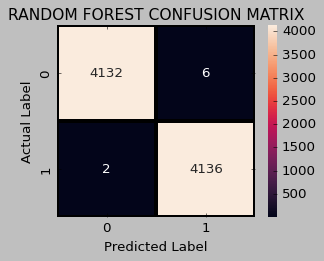


**********



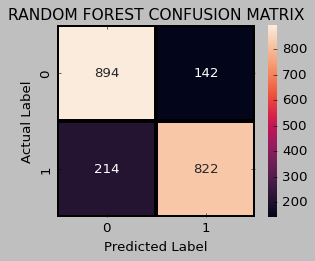

In [89]:
# instantiate the classifier with n_estimators = 100
model_rfc_200 = RandomForestClassifier(n_estimators=200, criterion='gini', random_state=0)

# fit the model to the training set
model_rfc_200.fit(X_smote_train, Y_smote_train)

# Predict on the test set results
Y_train_rfc_200 = model_rfc_200.predict(X_smote_train)
Y_test_rfc_200 = model_rfc_200.predict(X_smote_test)

# Check accuracy score 
print("Training Accuracy\t: {0:.0f}".format(model_rfc_200.score(X_smote_train, Y_smote_train)*100))
print("Testing Accuracy\t: {0:.0f}".format(model_rfc_200.score(X_smote_test, Y_smote_test)*100))

print("\n**********\n")

# CONFUSION MATRIX DATA TRAIN
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(Y_smote_train, Y_train_rfc_200),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title("RANDOM FOREST CONFUSION MATRIX",fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

print("\n**********\n")

# CONFUSION MATRIX DATA TEST
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(Y_smote_test, Y_test_rfc_200),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title("RANDOM FOREST CONFUSION MATRIX",fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [90]:
model_rfc_200 = RandomForestClassifier(n_estimators=200, criterion='gini', random_state=0)
model_rfc_200.fit(X_smote_train, Y_smote_train)

Y_train_rfc_200 = model_rfc_200.predict(X_smote_train)
Y_test_rfc_200 = model_rfc_200.predict(X_smote_test)

In [91]:
classification_matrix(Y_smote_train, Y_train_rfc_200, 'Random Forest Training')

Evaluation Model: Random Forest Training
[[4132    6]
 [   2 4136]]
Accuracy   : 99.9 %
Precision  : 99.86 %
Recall     : 99.95 %
F1_Score   : 100 %


In [92]:
print(metrics.classification_report(Y_smote_train, Y_train_rfc_200))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4138
           1       1.00      1.00      1.00      4138

    accuracy                           1.00      8276
   macro avg       1.00      1.00      1.00      8276
weighted avg       1.00      1.00      1.00      8276



In [93]:
classification_matrix(Y_smote_test, Y_test_rfc_200, 'Random Forest Testing')

Evaluation Model: Random Forest Testing
[[894 142]
 [214 822]]
Accuracy   : 82.82 %
Precision  : 85.27 %
Recall     : 79.34 %
F1_Score   : 82 %


In [94]:
print(metrics.classification_report(Y_smote_test, Y_test_rfc_200))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1036
           1       0.85      0.79      0.82      1036

    accuracy                           0.83      2072
   macro avg       0.83      0.83      0.83      2072
weighted avg       0.83      0.83      0.83      2072



#### c. 500 Trees = 82%

Training Accuracy	: 100
Testing Accuracy	: 83

**********



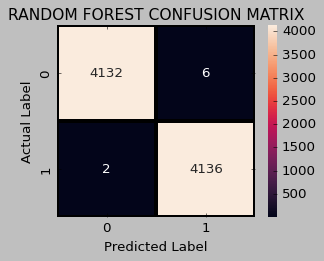


**********



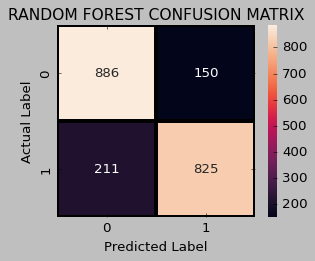

In [95]:
# instantiate the classifier with n_estimators = 500
model_rfc_500 = RandomForestClassifier(n_estimators=500, criterion='gini', random_state=0)

# fit the model to the training set
model_rfc_500.fit(X_smote_train, Y_smote_train)

# Predict on the test set results
Y_train_rfc_500 = model_rfc_500.predict(X_smote_train)
Y_test_rfc_500 = model_rfc_500.predict(X_smote_test)

# Check accuracy score 
print("Training Accuracy\t: {0:.0f}".format(model_rfc_500.score(X_smote_train, Y_smote_train)*100))
print("Testing Accuracy\t: {0:.0f}".format(model_rfc_500.score(X_smote_test, Y_smote_test)*100))

print("\n**********\n")

# CONFUSION MATRIX DATA TRAIN
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(Y_smote_train, Y_train_rfc_500),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title("RANDOM FOREST CONFUSION MATRIX",fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

print("\n**********\n")

# CONFUSION MATRIX DATA TEST
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(Y_smote_test, Y_test_rfc_500),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title("RANDOM FOREST CONFUSION MATRIX",fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [96]:
model_rfc_500 = RandomForestClassifier(n_estimators=500, criterion='gini', random_state=0)
model_rfc_500.fit(X_smote_train, Y_smote_train)

Y_train_rfc_500 = model_rfc_500.predict(X_smote_train)
Y_test_rfc_500 = model_rfc_500.predict(X_smote_test)

In [97]:
classification_matrix(Y_smote_train, Y_train_rfc_500, 'Random Forest Training')

Evaluation Model: Random Forest Training
[[4132    6]
 [   2 4136]]
Accuracy   : 99.9 %
Precision  : 99.86 %
Recall     : 99.95 %
F1_Score   : 100 %


In [98]:
print(metrics.classification_report(Y_smote_train, Y_train_rfc_500))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4138
           1       1.00      1.00      1.00      4138

    accuracy                           1.00      8276
   macro avg       1.00      1.00      1.00      8276
weighted avg       1.00      1.00      1.00      8276



In [99]:
classification_matrix(Y_smote_test, Y_test_rfc_500, 'Random Forest Testing')

Evaluation Model: Random Forest Testing
[[886 150]
 [211 825]]
Accuracy   : 82.58 %
Precision  : 84.62 %
Recall     : 79.63 %
F1_Score   : 82 %


In [100]:
print(metrics.classification_report(Y_smote_test, Y_test_rfc_500))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1036
           1       0.85      0.80      0.82      1036

    accuracy                           0.83      2072
   macro avg       0.83      0.83      0.83      2072
weighted avg       0.83      0.83      0.83      2072



#### d. 1000 Trees = 82%

Training Accuracy	: 100
Testing Accuracy	: 83

**********



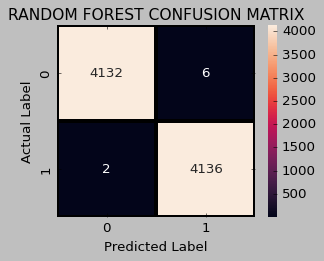


**********



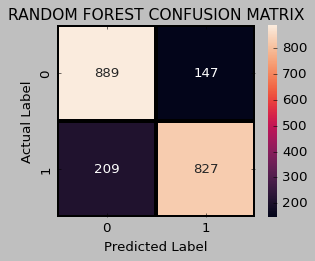

In [101]:
# instantiate the classifier with n_estimators = 1000
model_rfc_1000 = RandomForestClassifier(n_estimators=1000, criterion='gini', random_state=0)

# fit the model to the training set
model_rfc_1000.fit(X_smote_train, Y_smote_train)

# Predict on the test set results
Y_train_rfc_1000 = model_rfc_1000.predict(X_smote_train)
Y_test_rfc_1000 = model_rfc_1000.predict(X_smote_test)

# Check accuracy score 
print("Training Accuracy\t: {0:.0f}".format(model_rfc_1000.score(X_smote_train, Y_smote_train)*100))
print("Testing Accuracy\t: {0:.0f}".format(model_rfc_1000.score(X_smote_test, Y_smote_test)*100))

print("\n**********\n")

# CONFUSION MATRIX DATA TRAIN
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(Y_smote_train, Y_train_rfc_1000),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title("RANDOM FOREST CONFUSION MATRIX",fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

print("\n**********\n")

# CONFUSION MATRIX DATA TEST
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(Y_smote_test, Y_test_rfc_1000),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title("RANDOM FOREST CONFUSION MATRIX",fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [102]:
model_rfc_1000 = RandomForestClassifier(n_estimators=1000, criterion='gini', random_state=0)
model_rfc_1000.fit(X_smote_train, Y_smote_train)

Y_train_rfc_1000 = model_rfc_1000.predict(X_smote_train)
Y_test_rfc_1000 = model_rfc_1000.predict(X_smote_test)

In [103]:
classification_matrix(Y_smote_train, Y_train_rfc_1000, 'Random Forest Training')

Evaluation Model: Random Forest Training
[[4132    6]
 [   2 4136]]
Accuracy   : 99.9 %
Precision  : 99.86 %
Recall     : 99.95 %
F1_Score   : 100 %


In [104]:
print(metrics.classification_report(Y_smote_train, Y_train_rfc_1000))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4138
           1       1.00      1.00      1.00      4138

    accuracy                           1.00      8276
   macro avg       1.00      1.00      1.00      8276
weighted avg       1.00      1.00      1.00      8276



In [105]:
classification_matrix(Y_smote_test, Y_test_rfc_1000, 'Random Forest Testing')

Evaluation Model: Random Forest Testing
[[889 147]
 [209 827]]
Accuracy   : 82.82 %
Precision  : 84.91 %
Recall     : 79.83 %
F1_Score   : 82 %


In [106]:
print(metrics.classification_report(Y_smote_test, Y_test_rfc_1000))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1036
           1       0.85      0.80      0.82      1036

    accuracy                           0.83      2072
   macro avg       0.83      0.83      0.83      2072
weighted avg       0.83      0.83      0.83      2072



#### e. 2000 Trees = 82%

Training Accuracy	: 100
Testing Accuracy	: 83

**********



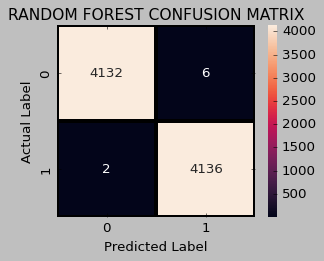


**********



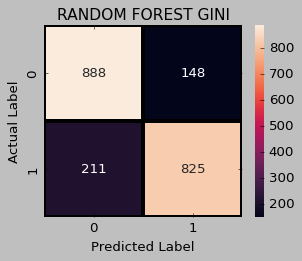

In [107]:
# instantiate the classifier with n_estimators = 2000
model_rfc_2000 = RandomForestClassifier(n_estimators=2000, criterion='gini', random_state=0)

# fit the model to the training set
model_rfc_2000.fit(X_smote_train, Y_smote_train)

# Predict on the test set results
Y_train_rfc_2000 = model_rfc_2000.predict(X_smote_train)
Y_test_rfc_2000 = model_rfc_2000.predict(X_smote_test)

# Check accuracy score 
print("Training Accuracy\t: {0:.0f}".format(model_rfc_2000.score(X_smote_train, Y_smote_train)*100))
print("Testing Accuracy\t: {0:.0f}".format(model_rfc_2000.score(X_smote_test, Y_smote_test)*100))

print("\n**********\n")

# CONFUSION MATRIX DATA TRAIN
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(Y_smote_train, Y_train_rfc_2000),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title("RANDOM FOREST CONFUSION MATRIX",fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

print("\n**********\n")

# CONFUSION MATRIX DATA TEST
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(Y_smote_test, Y_test_rfc_2000),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title("RANDOM FOREST GINI",fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [108]:
model_rfc_2000 = RandomForestClassifier(n_estimators=1000, criterion='gini', random_state=0)
model_rfc_2000.fit(X_smote_train, Y_smote_train)

Y_train_rfc_2000 = model_rfc_2000.predict(X_smote_train)
Y_test_rfc_2000 = model_rfc_2000.predict(X_smote_test)

In [109]:
classification_matrix(Y_smote_train, Y_train_rfc_2000, 'Random Forest Training')

Evaluation Model: Random Forest Training
[[4132    6]
 [   2 4136]]
Accuracy   : 99.9 %
Precision  : 99.86 %
Recall     : 99.95 %
F1_Score   : 100 %


In [110]:
print(metrics.classification_report(Y_smote_train, Y_train_rfc_2000))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4138
           1       1.00      1.00      1.00      4138

    accuracy                           1.00      8276
   macro avg       1.00      1.00      1.00      8276
weighted avg       1.00      1.00      1.00      8276



In [111]:
classification_matrix(Y_smote_test, Y_test_rfc_2000, 'Random Forest Testing')

Evaluation Model: Random Forest Testing
[[889 147]
 [209 827]]
Accuracy   : 82.82 %
Precision  : 84.91 %
Recall     : 79.83 %
F1_Score   : 82 %


In [112]:
print(metrics.classification_report(Y_smote_test, Y_test_rfc_2000))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1036
           1       0.85      0.80      0.82      1036

    accuracy                           0.83      2072
   macro avg       0.83      0.83      0.83      2072
weighted avg       0.83      0.83      0.83      2072



### 5.1.4 Feature Impotances

In [113]:
# view the feature scores
feature_scores = pd.Series(entropy_rfc_2000.feature_importances_, 
                           index=X_smote_train.columns
                          ).sort_values(ascending=False)
feature_scores

TotalCharges                               0.138188
tenure                                     0.136605
MonthlyCharges                             0.134323
Contract                                   0.123238
OnlineSecurity                             0.059758
TechSupport                                0.045615
PaperlessBilling                           0.036334
OnlineBackup                               0.029821
PaymentMethod_Electronic check             0.027134
InternetService_Fiber optic                0.026725
MultipleLines                              0.025036
Partner                                    0.024240
DeviceProtection                           0.022221
Dependents                                 0.022022
StreamingMovies                            0.019647
SeniorCitizen                              0.019277
StreamingTV                                0.018563
gender_Male                                0.016499
gender_Female                              0.016472
PaymentMetho

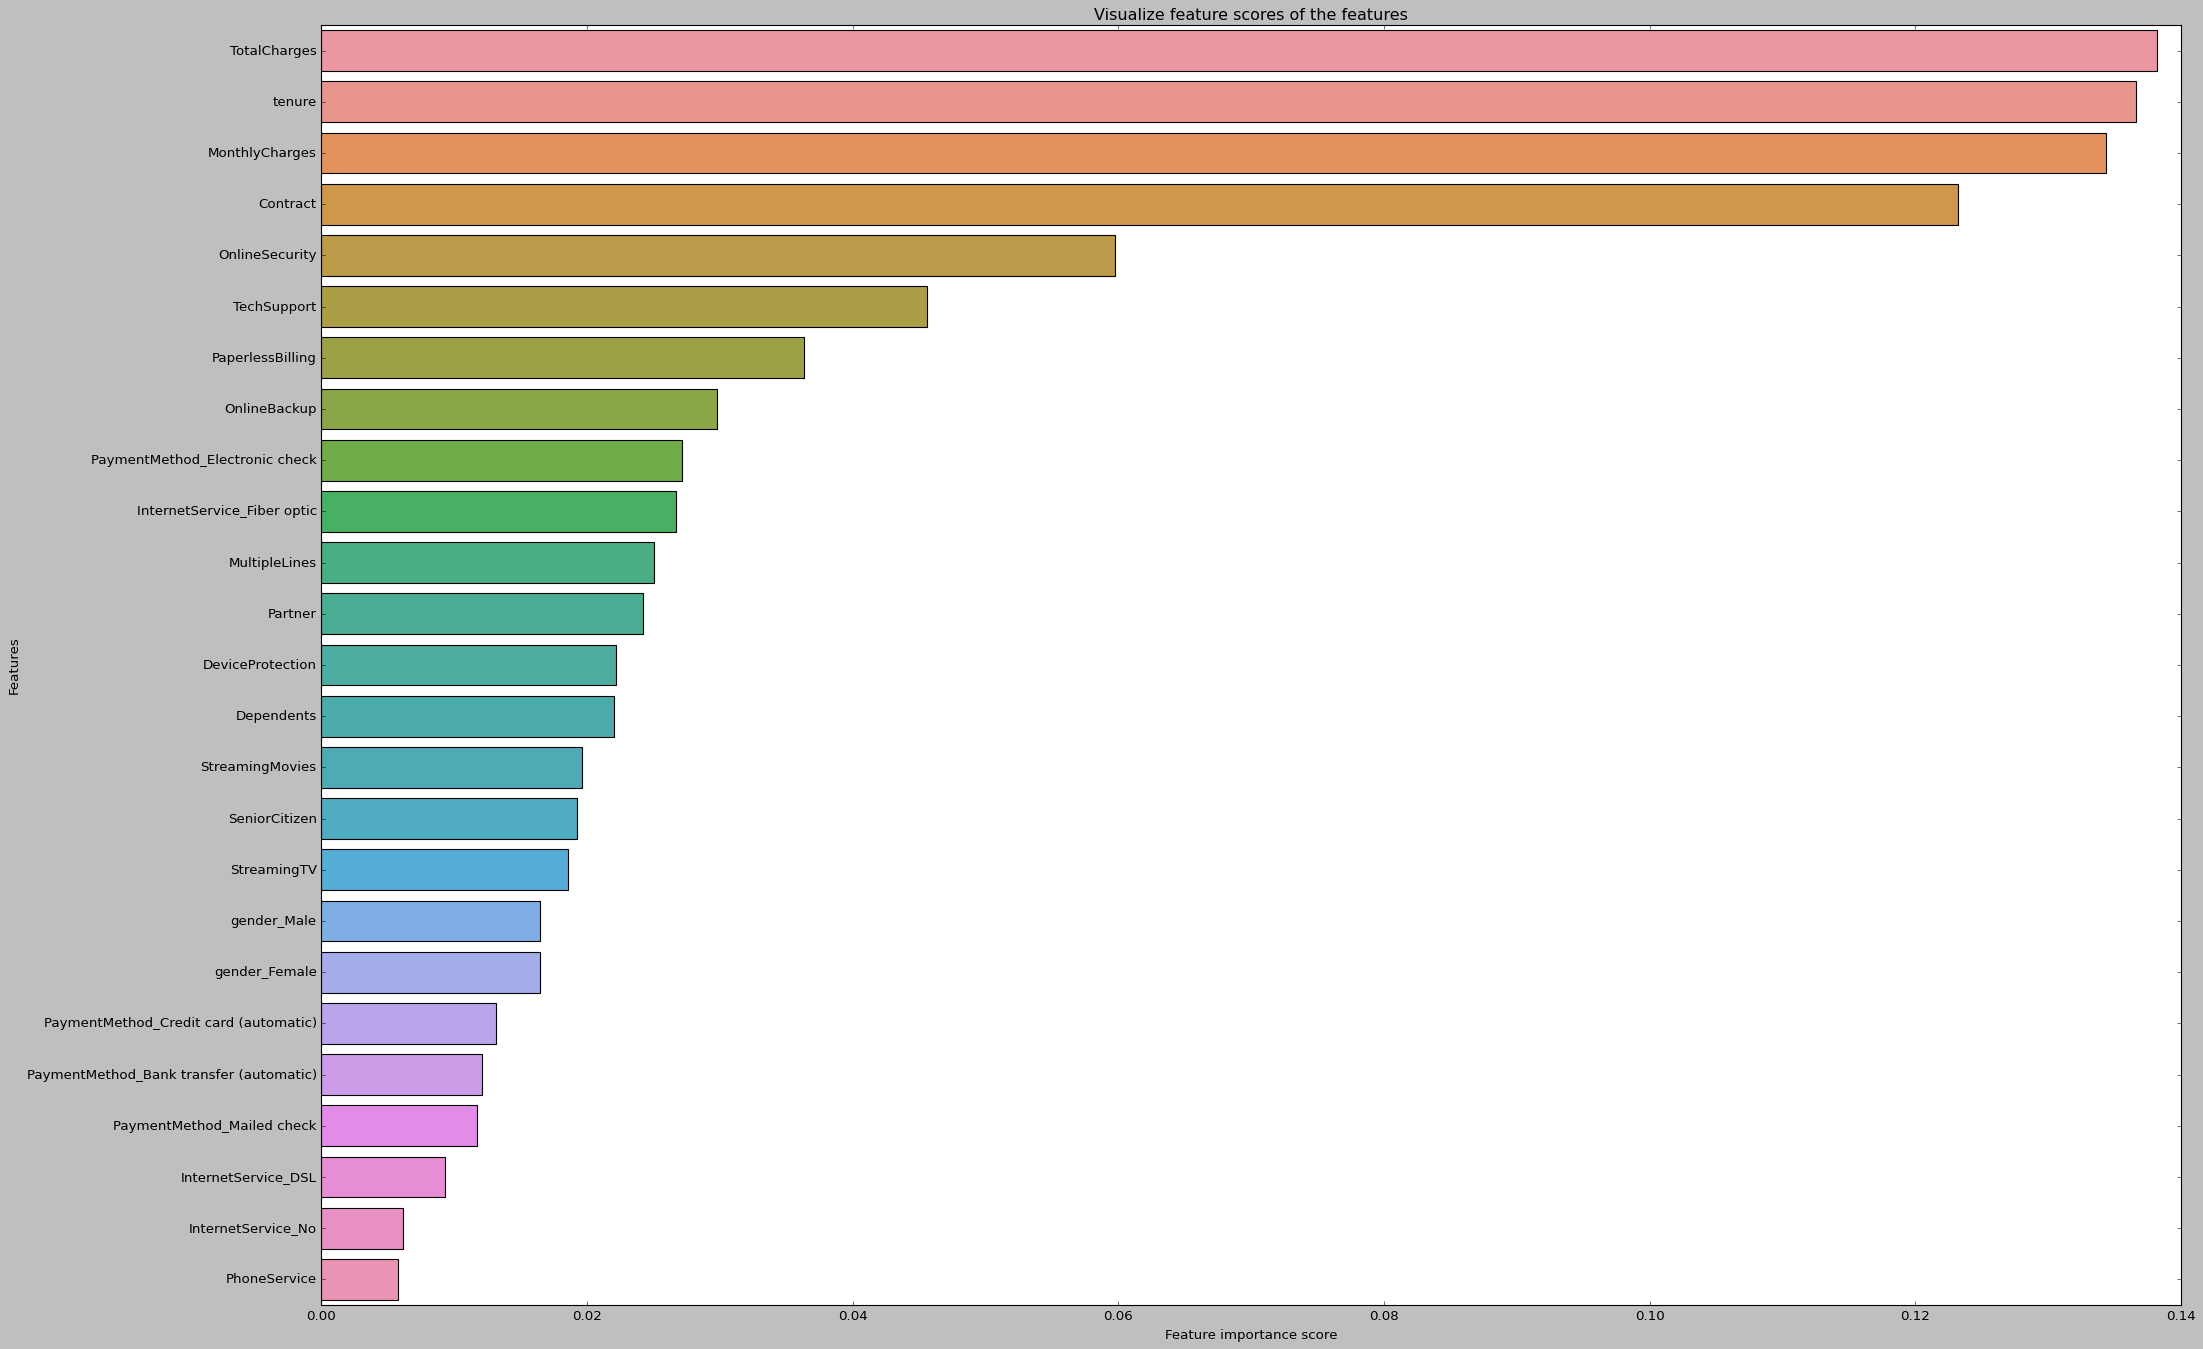

In [114]:
# Creating a seaborn bar plot
f,ax = plt.subplots(figsize=(30, 20))
ax = sns.barplot(x=feature_scores, y=feature_scores.index, data=df)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

### 5.1.5 Build the Random Forest model on selected features

Now, I will drop the least important feature `PhoneService` from the model, rebuild the model and check its effect on accuracy.

In [115]:
# drop the least important feature from X_train and X_test
X_smote_train.drop(['PhoneService', 'InternetService_DSL', 'InternetService_No'], axis=1)
X_smote_test.drop(['PhoneService', 'InternetService_DSL', 'InternetService_No'], axis=1)

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,InternetService_Fiber optic,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,...,Dependents,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling
0,0.000000,0.013889,0.065272,0.000692,1.0,0.0,0.000000,0.0,0.000000,1.000000,...,0.0,0.5,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,1.0
1,0.000000,0.569444,0.069756,0.112814,0.0,1.0,0.000000,1.0,0.000000,0.000000,...,0.0,1.0,0.500000,0.5,0.5,0.5,0.500000,0.5,0.000000,1.0
2,0.000000,0.722222,0.010962,0.116882,1.0,0.0,0.000000,0.0,0.000000,0.000000,...,1.0,0.0,0.500000,0.5,0.5,0.5,0.500000,0.5,1.000000,0.0
3,0.000000,0.013889,0.578974,0.006641,1.0,0.0,1.000000,0.0,0.000000,1.000000,...,0.0,0.0,0.000000,0.0,1.0,0.0,0.000000,0.0,0.000000,0.0
4,0.000000,0.930556,0.321873,0.374025,0.0,1.0,0.000000,1.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,1.0,0.000000,0.0,1.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2067,0.555356,0.271577,0.824003,0.226837,0.0,1.0,1.000000,0.0,0.000000,1.000000,...,0.0,1.0,0.000000,1.0,0.0,0.0,1.000000,1.0,0.000000,1.0
2068,0.000000,0.056334,0.515033,0.036810,1.0,0.0,0.186912,0.0,0.000000,0.186912,...,1.0,0.0,0.000000,0.0,0.0,0.0,1.000000,1.0,0.000000,0.0
2069,0.000000,0.889742,0.710727,0.657843,0.0,1.0,1.000000,0.0,0.804093,0.195907,...,0.0,0.0,0.804093,1.0,0.0,0.0,0.000000,1.0,0.402047,1.0
2070,0.043664,0.346556,0.699102,0.249619,1.0,0.0,1.000000,1.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.956336,1.0,0.000000,1.0


Now, I will build the random forest model again and check accuracy.

In [116]:
# instantiate the classifier with n_estimators = 1000
test_rfc = RandomForestClassifier(n_estimators=1000, random_state=0)

# fit the model to the training set
test_rfc.fit(X_smote_train, Y_smote_train)

# Predict on the test set results
y_pred_rfc = test_rfc.predict(X_smote_test)

# Check accuracy score 
print('Model accuracy score with native_country_41 variable removed : {0:0.2f}'. format(accuracy_score(Y_smote_test, y_pred_rfc)))

Model accuracy score with native_country_41 variable removed : 0.83


> Interpretation

- I have removed the `native_country_41` variable from the model, rebuild it and checked its accuracy. 

- The accuracy of the model now comes out to be 0.8544. 

- The accuracy of the model with all the variables taken into account is 0.8521. 

- So, we can see that the model accuracy has been improved with `native_country_41` variable removed from the model.

Now, based on the above analysis we can conclude that our classification model accuracy is very good. Our model is doing a very good job in terms of predicting the class labels.


But, it does not give the underlying distribution of values. Also, it does not tell anything about the type of errors our classifer is making. 


We have another tool called `Confusion matrix` that comes to our rescue.

## 5.2.2 Naive Bayes
Referensi Model Random Forest
1. [Cross Validation](https://www.kaggle.com/code/prashant111/naive-bayes-classifier-in-python)
2. [Perhitungan Probabilitas](https://www.trivusi.web.id/2022/07/algoritma-naive-bayes.html)

In [117]:
model_nbc = GaussianNB()
model_nbc.fit(X_smote_train, Y_smote_train)

GaussianNB()

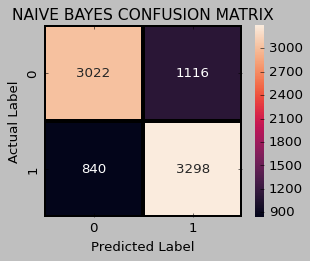


**********



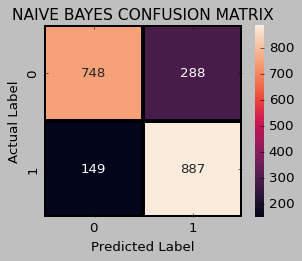


**********

Training Accuracy	: 76
Testing Accuracy	: 79


In [118]:
Y_train_nbc = model_nbc.predict(X_smote_train)
Y_test_nbc = model_nbc.predict(X_smote_test)

plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(
                              Y_smote_train, Y_train_nbc),
                              annot=True,
                              fmt="d",
                              linecolor="k",
                              linewidths=3
                            )
    
plt.title("NAIVE BAYES CONFUSION MATRIX", fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

print("\n**********\n")

plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(
                              Y_smote_test, Y_test_nbc),
                              annot=True,
                              fmt="d",
                              linecolor="k",
                              linewidths=3
                            )
    
plt.title("NAIVE BAYES CONFUSION MATRIX", fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

print("\n**********\n")

# Check accuracy score 
print("Training Accuracy\t: {0:.0f}".format(model_nbc.score(X_smote_train, Y_smote_train)*100))
print("Testing Accuracy\t: {0:.0f}".format(model_nbc.score(X_smote_test, Y_smote_test)*100))

In [119]:
classification_matrix(Y_smote_train, Y_train_nbc, 'Naive Bayes Training')

Evaluation Model: Naive Bayes Training
[[3022 1116]
 [ 840 3298]]
Accuracy   : 76.37 %
Precision  : 74.72 %
Recall     : 79.7 %
F1_Score   : 77 %


In [120]:
print(metrics.classification_report(Y_smote_train, Y_train_nbc))

              precision    recall  f1-score   support

           0       0.78      0.73      0.76      4138
           1       0.75      0.80      0.77      4138

    accuracy                           0.76      8276
   macro avg       0.76      0.76      0.76      8276
weighted avg       0.76      0.76      0.76      8276



In [121]:
classification_matrix(Y_smote_test, Y_test_nbc, 'Naive Bayes Testing')

Evaluation Model: Naive Bayes Testing
[[748 288]
 [149 887]]
Accuracy   : 78.91 %
Precision  : 75.49 %
Recall     : 85.62 %
F1_Score   : 80 %


In [122]:
print(metrics.classification_report(Y_smote_test, Y_test_nbc))

              precision    recall  f1-score   support

           0       0.83      0.72      0.77      1036
           1       0.75      0.86      0.80      1036

    accuracy                           0.79      2072
   macro avg       0.79      0.79      0.79      2072
weighted avg       0.79      0.79      0.79      2072



# Overfitting dan Underfitting
Tidak dibahas di penelitian ini

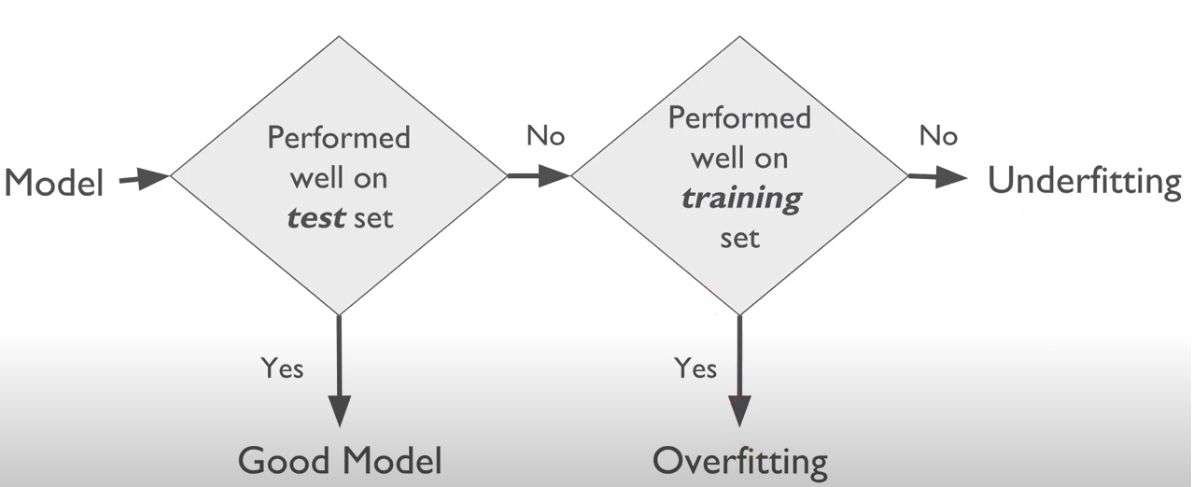

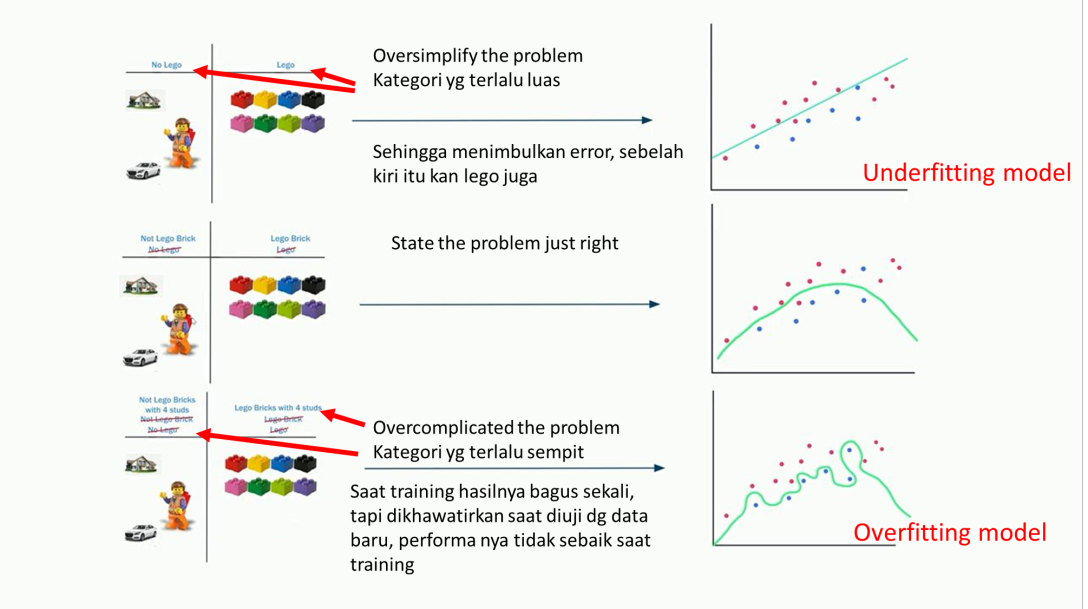

Kemudian untuk mencegah over/under fitting, cara yang paling populer adalah : 
- Cross-validation
- Train model dg lbh byk data (klo memungkinkan)
- Data augmentation
- Simplifikasi data (drop na, reduce dimension, reduce depth di decision tree, dropout di neural network dll)
- Regularization
- Ensembling
- Early stopping

Cara yg sudah kita lakukan yaitu memisahkan train, test dan validate data itu juga salah satu cara mencegah over/under fitting